In [ ]:
#!pip install hawkesbook
#!pip install newsapi-python
#!pip install pytrends

In [ ]:
# -*- coding: utf-8 -*-
import requests # Utilisé pour les requêtes manuelles à Polygon
import pandas as pd
import numpy as np
import datetime as dt
import time
from pytrends.request import TrendReq
import pandas_datareader.data as web
# NLTK n'est plus nécessaire car nous n'utilisons plus NewsAPI pour le sentiment
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools
import os
import warnings
import hawkesbook as hl

In [ ]:
# --- Configuration ---
# ATTENTION: Remplacez par votre vraie clé API !
POLYGON_API_KEY = "YOUR API KEY" # Mettez votre clé ici
# NEWSAPI_KEY n'est plus nécessaire

# Actions NASDAQ (Exemple)
TICKERS = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA', 'MRNA', 'SBUX', 'CMCSA']
N_STOCKS = len(TICKERS)

# Période d'analyse
END_DATE = dt.date.today()
START_DATE = END_DATE - dt.timedelta(days=365*2) # 1 an

# Paramètres temporels
TIME_STEP = 5 # minutes
ROLLING_VOL_WINDOW_DAYS = 7
EPISODE_DURATION_WEEKS = 1
PAGINATION_RANGE_DAYS = 30 # Récupérer les données Polygon par tranches de 30 jours pour éviter les limites

# Paramètres de détection d'événements
VOLATILITY_THRESHOLD_QUANTILE = 0.92

# Paramètres Hawkes (pour l'estimation MLE)
INITIAL_LAMBDA = np.ones(N_STOCKS) * 0.1
INITIAL_ALPHA = np.ones((N_STOCKS, N_STOCKS)) * 0.05
np.fill_diagonal(INITIAL_ALPHA, 0.1)
INITIAL_BETA = np.ones(N_STOCKS) * 1.0
INITIAL_THETA = (INITIAL_LAMBDA, INITIAL_ALPHA, INITIAL_BETA)

# Indicateurs Macroéconomiques (FRED) - Ajout de VXN
FRED_INDICATORS = {
    'VIX': 'VIXCLS',       # Indice de Volatilité CBOE
    'VXN': 'VXNCLS',       # Indice de Volatilité NASDAQ-100
    'UNRATE': 'UNRATE',    # Taux de chômage US
    'CPI': 'CPIAUCSL',     # Indice des prix à la consommation US
    'FEDFUNDS': 'FEDFUNDS' # Taux des fonds fédéraux
}

# Keywords pour Google Trends - Ajout de comparaisons par paire
TRENDS_KEYWORDS_PER_STOCK = {ticker: [ticker] for ticker in TICKERS}
TRENDS_KEYWORDS_THEMES = [
    'semiconductor shortage', 'AI regulation', 'cloud computing competition', 'supply chain disruption',
    'Apple vs Microsoft', 'Nvidia vs AMD', 'Tesla vs Ford' # Exemples de paires
]

In [ ]:
# --- Fonctions ---

def fetch_polygon_data_manual(tickers, start_date, end_date, api_key, timespan='minute', multiplier=5, pagination_days=30):
    """Récupère les données de prix historiques de Polygon.io manuellement avec requests, gère la pagination et les limites de taux."""
    print(f"Récupération manuelle des données Polygon pour {len(tickers)} tickers...")
    base_url = "https://api.polygon.io"
    all_ticker_data = {ticker: [] for ticker in tickers}
    requests_count = 0
    minute_start_time = time.time()

    # Headers pour l'authentification
    headers = {
        "Authorization": f"Bearer {api_key}"
    }

    # Boucle sur les tickers
    for ticker in tqdm(tickers, desc="Tickers"):
        current_start_date = start_date
        # Boucle de pagination par date
        while current_start_date <= end_date:
            # Définir la fin de la période de pagination
            current_end_date = min(current_start_date + dt.timedelta(days=pagination_days - 1), end_date)
            start_str = current_start_date.strftime("%Y-%m-%d")
            end_str = current_end_date.strftime("%Y-%m-%d")

            # Construire l'URL de l'endpoint
            endpoint = f"/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_str}/{end_str}"
            url = base_url + endpoint
            params = {"adjusted": "true", "sort": "asc", "limit": 50000} # Max limit

            # --- Gestion de la limite de taux (5 requêtes/minute pour le plan gratuit) ---
            current_time = time.time()
            if requests_count >= 4 and (current_time - minute_start_time) < 60:
                sleep_time = 60 - (current_time - minute_start_time) + 1 # +1 pour la marge
                print(f"Limite de taux atteinte, attente de {sleep_time:.1f} secondes...")
                time.sleep(sleep_time)
                requests_count = 0
                minute_start_time = time.time()
            elif (current_time - minute_start_time) >= 60:
                 requests_count = 0
                 minute_start_time = time.time()
            # --------------------------------------------------------------------------

            try:
                response = requests.get(url, headers=headers, params=params)
                requests_count += 1
                response.raise_for_status()
                data = response.json()

                if data.get("resultsCount", 0) > 0 and 'results' in data:
                    df = pd.DataFrame(data['results'])
                    df = df.rename(columns={'t': 'timestamp', 'c': ticker})
                    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
                    df = df.set_index('timestamp')
                    all_ticker_data[ticker].append(df[[ticker]])
                # Même si les résultats sont vides, on avance la date
                current_start_date = current_end_date + dt.timedelta(days=1)
                # Petite pause entre chaque requête individuelle pour être sûr
                time.sleep(0.5)

            except requests.exceptions.RequestException as e:
                print(f"Erreur lors de la requête pour {ticker} ({start_str} à {end_str}): {e}")
                if response is not None:
                     print(f"Status Code: {response.status_code}, Response: {response.text[:200]}") # Affiche début de la réponse si erreur
                     if response.status_code == 429: # Rate limit explicite
                         print("Rate limit (429) détecté, attente de 65 secondes...")
                         time.sleep(65)
                         requests_count = 0 # Réinitialiser le compteur après attente
                         minute_start_time = time.time()
                         continue # Retenter la même requête
                # Si autre erreur, on saute cette période pour ce ticker mais on continue
                current_start_date = current_end_date + dt.timedelta(days=1)
                time.sleep(2) # Pause après une erreur

            except Exception as e_json:
                 print(f"Erreur de décodage JSON ou autre pour {ticker} ({start_str} à {end_str}): {e_json}")
                 # Si erreur, on saute cette période pour ce ticker mais on continue
                 current_start_date = current_end_date + dt.timedelta(days=1)
                 time.sleep(2)


    # Combiner les données pour chaque ticker puis tous les tickers
    final_dfs = []
    for ticker in tickers:
        if all_ticker_data[ticker]:
            ticker_df = pd.concat(all_ticker_data[ticker]).sort_index()
            # Supprimer les duplicatas d'index si la pagination a des chevauchements minimes
            ticker_df = ticker_df[~ticker_df.index.duplicated(keep='first')]
            final_dfs.append(ticker_df)
        else:
            print(f"Aucune donnée valide récupérée pour {ticker}")

    if not final_dfs:
        print("Aucune donnée n'a pu être récupérée pour aucun ticker.")
        return pd.DataFrame()

    # Combiner tous les tickers
    full_df = pd.concat(final_dfs, axis=1)
    # Remplir les NaNs (peut arriver si les tickers n'ont pas exactement les mêmes timestamps)
    full_df = full_df.ffill().bfill()
    print("Données Polygon récupérées manuellement.")
    return full_df


def calculate_volatility_and_events(price_df, window_days, timestep_min, quantile_threshold):
    """Calcule la volatilité et détecte les événements de forte volatilité."""
    print("Calcul de la volatilité et détection des événements...")
    log_returns = np.log(price_df / price_df.shift(1)).dropna()

    trading_periods_per_day = (6.5 * 60) / timestep_min # Approximation heures de trading (ex: 9:30-16:00 ET)
    window_size = int(window_days * trading_periods_per_day)

    if window_size <= 1:
        raise ValueError("Fenêtre de volatilité trop petite.")

    rolling_vol = log_returns.rolling(window=window_size, min_periods=int(window_size*0.8)).std().dropna() # min_periods ajouté

    events = []
    thresholds = {}
    for ticker in price_df.columns:
        if ticker not in rolling_vol.columns or rolling_vol[ticker].isnull().all():
            print(f"Pas de données de volatilité pour {ticker}, il est ignoré.")
            continue
        vol = rolling_vol[ticker]
        try:
            threshold = vol.quantile(quantile_threshold)
            thresholds[ticker] = threshold
        except Exception as e:
             print(f"Impossible de calculer le quantile pour {ticker}, seuil mis à NaN: {e}")
             thresholds[ticker] = np.nan
             continue # Ne pas chercher d'événements si seuil non calculable

        if pd.isna(threshold): continue

        high_vol_times = vol[vol > threshold].index
        ticker_id = list(price_df.columns).index(ticker)
        for t in high_vol_times:
            time_in_days = (t - price_df.index[0]).total_seconds() / (24 * 60 * 60)
            events.append({'timestamp': t, 'time_days': time_in_days, 'ticker': ticker, 'ticker_id': ticker_id})

    print(f"Détection de {len(events)} événements de forte volatilité.")
    if not events:
        print("Aucun événement détecté.")
        return pd.DataFrame(), pd.DataFrame(), {}

    events_df = pd.DataFrame(events).sort_values('timestamp').reset_index(drop=True)
    return rolling_vol, events_df, thresholds

# Fonction pour récupérer les tendances Google - inchangée mais utilisera les keywords étendus
def fetch_trends_data(keywords_dict, themes, start_date, end_date, episode_starts):
    """Récupère les données Google Trends agrégées par épisode."""
    print("Récupération des données Google Trends...")
    pytrends = TrendReq(hl='en-US', tz=360)
    trends_data = []

    all_keywords = list(itertools.chain(*keywords_dict.values())) + themes
    # Attention : certains keywords peuvent ne retourner aucune donnée.
    # Google Trends limite à 5 keywords par requête
    kw_groups = [all_keywords[i:i + 5] for i in range(0, len(all_keywords), 5)]

    trends_df = pd.DataFrame()
    timeframe = f"{start_date.strftime('%Y-%m-%d')} {end_date.strftime('%Y-%m-%d')}"

    for kw_group in tqdm(kw_groups, desc="Fetching Trends"):
        # Filtrer les éventuels keywords vides ou None
        kw_group = [kw for kw in kw_group if kw]
        if not kw_group: continue
        try:
            pytrends.build_payload(kw_group, cat=0, timeframe=timeframe, geo='', gprop='')
            interest_over_time_df = pytrends.interest_over_time()
            if 'isPartial' in interest_over_time_df.columns:
                 interest_over_time_df = interest_over_time_df.drop(columns=['isPartial'])

            if trends_df.empty:
                trends_df = interest_over_time_df
            else:
                # Join en gérant les colonnes manquantes dans l'un ou l'autre
                trends_df = trends_df.join(interest_over_time_df, how='outer')
            time.sleep(2)
        except Exception as e:
            print(f"Erreur Pytrends pour {kw_group}: {e}.")
            # Ajouter des colonnes vides si nécessaire pour la cohérence
            for kw in kw_group:
                if kw not in trends_df.columns: trends_df[kw] = np.nan

    if trends_df.empty:
        print("Aucune donnée Google Trends trouvée.")
        return pd.DataFrame()

    # Agréger par épisode (moyenne)
    # Note : resample fonctionne mieux avec un index DatetimeIndex
    trends_df.index = pd.to_datetime(trends_df.index)
    trends_agg = trends_df.resample(f'{EPISODE_DURATION_WEEKS*7}D').mean()

    # Aligner sur les débuts d'épisodes et remplir
    trends_agg = trends_agg.reindex(episode_starts, method='ffill').fillna(0)
    trends_agg.columns = ['Trend_'+col.replace(' ', '_') for col in trends_agg.columns] # Remplacer espaces

    print("Données Google Trends agrégées.")
    return trends_agg

# Fonction pour récupérer les données macro FRED - inchangée mais utilisera les indicateurs étendus
def fetch_macro_data(fred_indicators, start_date, end_date, episode_starts):
    """Récupère les données macroéconomiques de FRED agrégées par épisode."""
    print("Récupération des données macroéconomiques FRED...")
    try:
        # Essayer de récupérer les données
        macro_df = web.DataReader(list(fred_indicators.values()), 'fred', start_date, end_date)
        # Renommer les colonnes avec les clés fournies
        name_map = {v: k for k, v in fred_indicators.items()}
        macro_df = macro_df.rename(columns=name_map)

        # Agréger par épisode (prendre la dernière valeur)
        # Assurer que l'index est un DatetimeIndex
        macro_df.index = pd.to_datetime(macro_df.index)
        macro_agg = macro_df.resample(f'{EPISODE_DURATION_WEEKS*7}D').last()

        # Aligner sur les débuts d'épisodes et remplir les NaNs
        macro_agg = macro_agg.reindex(episode_starts, method='ffill')
        macro_agg = macro_agg.fillna(method='ffill').fillna(method='bfill') # Fill forward puis backward

        macro_agg.columns = ['Macro_'+col for col in macro_agg.columns]
        print("Données macroéconomiques agrégées.")
        return macro_agg
    except Exception as e:
        print(f"Erreur lors de la récupération des données FRED: {e}")
        # Retourner un DataFrame vide avec les colonnes attendues si erreur
        cols = ['Macro_'+k for k in fred_indicators.keys()]
        return pd.DataFrame(columns=cols, index=episode_starts)

# Nouvelle fonction pour calculer les corrélations glissantes par épisode
def calculate_rolling_correlations(price_df, episode_starts):
    """Calcule la corrélation des log-rendements entre les paires d'actions pour chaque épisode."""
    print("Calcul des corrélations par épisode...")
    log_returns = np.log(price_df / price_df.shift(1)).dropna()
    correlation_features = []

    ticker_pairs = list(itertools.combinations(price_df.columns, 2))
    column_names = [f"Corr_{p[0]}_{p[1]}" for p in ticker_pairs]

    for i in range(len(episode_starts)):
        ep_start = episode_starts[i]
        ep_end = episode_starts[i+1] if i+1 < len(episode_starts) else log_returns.index.max() + dt.timedelta(microseconds=1)

        episode_returns = log_returns[(log_returns.index >= ep_start) & (log_returns.index < ep_end)]

        correlations = {}
        if len(episode_returns) > 1: # Besoin d'au moins 2 points pour la corrélation
            corr_matrix = episode_returns.corr()
            for pair in ticker_pairs:
                col_name = f"Corr_{pair[0]}_{pair[1]}"
                # Vérifier si les tickers existent dans la matrice (peuvent être absents si pas de données)
                if pair[0] in corr_matrix.columns and pair[1] in corr_matrix.columns:
                     correlations[col_name] = corr_matrix.loc[pair[0], pair[1]]
                else:
                     correlations[col_name] = np.nan # Mettre NaN si un ticker manque
        else:
             for pair in ticker_pairs:
                col_name = f"Corr_{pair[0]}_{pair[1]}"
                correlations[col_name] = np.nan # Mettre NaN si pas assez de données

        correlations['episode_start'] = ep_start
        correlation_features.append(correlations)

    if not correlation_features:
        return pd.DataFrame(columns=['episode_start'] + column_names).set_index('episode_start')

    corr_df = pd.DataFrame(correlation_features).set_index('episode_start')
    # Remplir les NaNs (par ex., si épisode avec < 2 retours) avec 0 ou moyenne ? Prenons 0.
    corr_df = corr_df.fillna(0)
    print("Corrélations par épisode calculées.")
    return corr_df


# Fonction d'estimation Hawkes - inchangée
def estimate_hawkes_for_episode(events_in_episode, n_stocks, T_episode_days, initial_theta):
    """Estime les paramètres Hawkes pour un épisode donné."""
    if events_in_episode.empty or len(events_in_episode) < 2:
        nan_params = np.full(n_stocks + n_stocks**2 + n_stocks, np.nan)
        return nan_params

    times = events_in_episode['time_days'].values
    ids = events_in_episode['ticker_id'].values
    times = times - times[0]
    T = max(T_episode_days, times[-1] + 1e-6) # Assurer T >= max(time)

    try:
        # print(f"Estimating MLE for episode (T={T:.2f} days, N={len(times)} events)...")
        estimated_theta, log_likelihood = hl.mutual_exp_mle(times, ids, T, initial_theta)
        # print(f"Log-Likelihood: {log_likelihood:.2f}")
        flat_theta = hl.flatten_theta(estimated_theta)
        return flat_theta
    except Exception as e:
        print(f"Erreur durant l'estimation MLE: {e}")
        nan_params = np.full(n_stocks + n_stocks**2 + n_stocks, np.nan)
        return nan_params

# Fonction de plot - inchangée
def plot_point_process(events_df, tickers):
    """Affiche le point process multivarié."""
    plt.figure(figsize=(15, 6))
    # Utiliser les timestamps directement pour l'axe des x
    plt.scatter(events_df['timestamp'], events_df['ticker_id'], alpha=0.6, s=10)
    plt.yticks(range(len(tickers)), tickers)
    plt.xlabel("Date")
    plt.ylabel("Action")
    plt.title("Processus Ponctuel des Événements de Forte Volatilité (7 jours)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
# 1. Récupérer les données de prix (version manuelle)
price_data = fetch_polygon_data_manual(TICKERS, START_DATE, END_DATE, POLYGON_API_KEY,
                                     multiplier=TIME_STEP, pagination_days=PAGINATION_RANGE_DAYS)

if price_data.empty or price_data.shape[1] < N_STOCKS:
    print(f"Données de prix incomplètes ou manquantes (obtenues: {price_data.shape[1]}/{N_STOCKS}). Arrêt.")
    exit()

# S'assurer que l'index est trié
price_data = price_data.sort_index()

Récupération manuelle des données Polygon pour 8 tickers...


Tickers:   0%|          | 0/8 [00:00<?, ?it/s]

Limite de taux atteinte, attente de 53.7 secondes...
Limite de taux atteinte, attente de 53.9 secondes...
Limite de taux atteinte, attente de 54.2 secondes...
Limite de taux atteinte, attente de 53.9 secondes...
Limite de taux atteinte, attente de 54.0 secondes...
Limite de taux atteinte, attente de 53.6 secondes...


Tickers:  12%|█▎        | 1/8 [06:07<42:51, 367.38s/it]

Limite de taux atteinte, attente de 54.4 secondes...
Limite de taux atteinte, attente de 54.2 secondes...
Limite de taux atteinte, attente de 54.2 secondes...
Limite de taux atteinte, attente de 54.3 secondes...
Limite de taux atteinte, attente de 54.2 secondes...
Limite de taux atteinte, attente de 54.0 secondes...


Tickers:  25%|██▌       | 2/8 [12:15<36:45, 367.54s/it]

Limite de taux atteinte, attente de 53.7 secondes...
Limite de taux atteinte, attente de 54.0 secondes...
Limite de taux atteinte, attente de 54.2 secondes...
Limite de taux atteinte, attente de 53.5 secondes...
Limite de taux atteinte, attente de 54.0 secondes...
Limite de taux atteinte, attente de 54.0 secondes...


Tickers:  38%|███▊      | 3/8 [18:23<30:38, 367.76s/it]

Limite de taux atteinte, attente de 54.2 secondes...
Limite de taux atteinte, attente de 45.5 secondes...
Limite de taux atteinte, attente de 53.9 secondes...
Limite de taux atteinte, attente de 53.6 secondes...
Limite de taux atteinte, attente de 53.7 secondes...
Limite de taux atteinte, attente de 53.9 secondes...


Tickers:  50%|█████     | 4/8 [24:30<24:31, 367.78s/it]

Limite de taux atteinte, attente de 54.2 secondes...
Limite de taux atteinte, attente de 53.9 secondes...
Limite de taux atteinte, attente de 53.7 secondes...
Limite de taux atteinte, attente de 53.9 secondes...
Limite de taux atteinte, attente de 53.9 secondes...
Limite de taux atteinte, attente de 53.9 secondes...
Limite de taux atteinte, attente de 53.8 secondes...


Tickers:  62%|██████▎   | 5/8 [31:32<19:21, 387.20s/it]

Limite de taux atteinte, attente de 54.9 secondes...
Limite de taux atteinte, attente de 54.5 secondes...
Limite de taux atteinte, attente de 54.6 secondes...
Limite de taux atteinte, attente de 54.8 secondes...
Limite de taux atteinte, attente de 54.7 secondes...
Limite de taux atteinte, attente de 52.7 secondes...


Tickers:  75%|███████▌  | 6/8 [37:39<12:40, 380.49s/it]

Limite de taux atteinte, attente de 55.0 secondes...
Limite de taux atteinte, attente de 55.1 secondes...
Limite de taux atteinte, attente de 54.7 secondes...
Limite de taux atteinte, attente de 54.8 secondes...
Limite de taux atteinte, attente de 54.5 secondes...
Limite de taux atteinte, attente de 54.9 secondes...


Tickers:  88%|████████▊ | 7/8 [43:47<06:16, 376.26s/it]

Limite de taux atteinte, attente de 55.0 secondes...
Limite de taux atteinte, attente de 55.2 secondes...
Limite de taux atteinte, attente de 55.3 secondes...
Limite de taux atteinte, attente de 55.2 secondes...
Limite de taux atteinte, attente de 55.0 secondes...
Limite de taux atteinte, attente de 55.1 secondes...


Tickers: 100%|██████████| 8/8 [49:54<00:00, 374.35s/it]

Données Polygon récupérées manuellement.


In [ ]:
print(type(price_data))
print(price_data.shape)
print(365 * 10 * 12)

<class 'pandas.core.frame.DataFrame'>
(95837, 8)
43800


Calcul de la volatilité et détection des événements...
Détection de 53423 événements de forte volatilité.


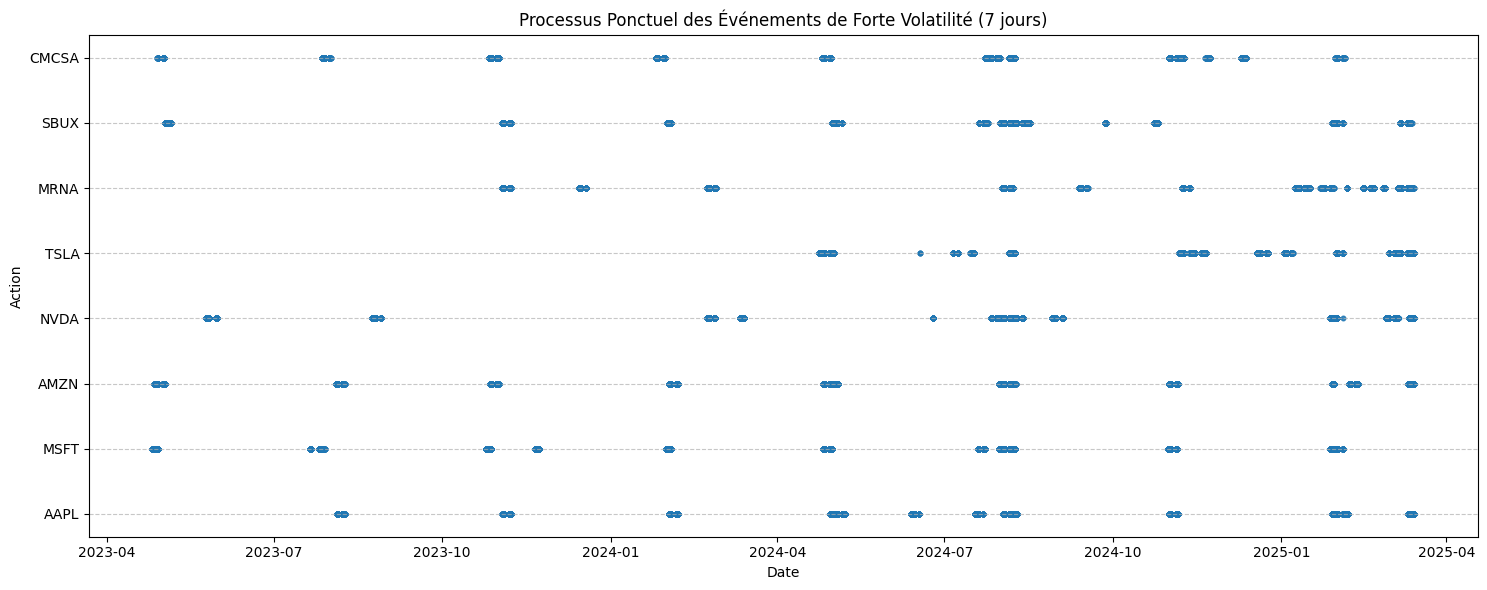

In [ ]:
# 2. Calculer la volatilité et détecter les événements
rolling_vol, events_df, vol_thresholds = calculate_volatility_and_events(
    price_data,
    ROLLING_VOL_WINDOW_DAYS,
    TIME_STEP,
    VOLATILITY_THRESHOLD_QUANTILE
)

if events_df.empty:
    print("Impossible de continuer sans événements de volatilité.")
    exit()

# Afficher le processus ponctuel
plot_point_process(events_df, list(price_data.columns)) # Utiliser les colonnes réelles de price_data

In [ ]:
# 3. Définir les épisodes de 2 semaines
episode_duration_td = dt.timedelta(weeks=EPISODE_DURATION_WEEKS)
# S'assurer que les épisodes commencent bien après le début des données pour la vol glissante
start_offset = dt.timedelta(days=ROLLING_VOL_WINDOW_DAYS + 1) # Ajouter une marge
analysis_start_date = price_data.index.min() + start_offset
episode_starts = pd.date_range(start=analysis_start_date.normalize(),
                               end=price_data.index.max().normalize(),
                               freq=episode_duration_td)

if episode_starts.empty:
     print("Aucun épisode complet trouvé après la période initiale de calcul de volatilité. Vérifiez les dates.")
     exit()

print(f"Nombre d'épisodes de {EPISODE_DURATION_WEEKS} semaines: {len(episode_starts)}")

Nombre d'épisodes de 1 semaines: 104


In [ ]:
# 4. Récupérer et agréger les indicateurs alternatifs
trends_agg = fetch_trends_data(TRENDS_KEYWORDS_PER_STOCK, TRENDS_KEYWORDS_THEMES, START_DATE, END_DATE, episode_starts)
macro_agg = fetch_macro_data(FRED_INDICATORS, START_DATE, END_DATE, episode_starts)
corr_agg = calculate_rolling_correlations(price_data, episode_starts)

# Fusionner tous les indicateurs agrégés
# news_agg est retiré
all_indicators = pd.concat([trends_agg, macro_agg, corr_agg], axis=1)

# Remplir les NaNs restants (peut arriver si une API a eu des erreurs)
all_indicators = all_indicators.fillna(method='ffill').fillna(method='bfill').fillna(0)

print("Indicateurs agrégés:")
#print(all_indicators.head())
print(all_indicators.shape)
print("Colonnes d'indicateurs:", all_indicators.columns)


# --- Note sur GDELT ---
#print("\nNote: Pour une analyse d'actualités open-source plus poussée (co-mentions, sentiment),")
#print("considérez GDELT Project. Son intégration demande un travail de traitement de données conséquent.")
# ---------------------

Récupération des données Google Trends...


Fetching Trends:  33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

Erreur Pytrends pour ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA']: The request failed: Google returned a response with code 429.


Fetching Trends:  67%|██████▋   | 2/3 [00:01<00:00,  1.56it/s]

Erreur Pytrends pour ['MRNA', 'SBUX', 'CMCSA', 'semiconductor shortage', 'AI regulation']: The request failed: Google returned a response with code 429.


Fetching Trends: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

Erreur Pytrends pour ['cloud computing competition', 'supply chain disruption', 'Apple vs Microsoft', 'Nvidia vs AMD', 'Tesla vs Ford']: The request failed: Google returned a response with code 429.
Aucune donnée Google Trends trouvée.
Récupération des données macroéconomiques FRED...


Erreur lors de la récupération des données FRED: Cannot compare dtypes datetime64[ns] and datetime64[ns, UTC]
Calcul des corrélations par épisode...
Corrélations par épisode calculées.
Indicateurs agrégés:
(104, 33)
Colonnes d'indicateurs: Index(['Macro_VIX', 'Macro_VXN', 'Macro_UNRATE', 'Macro_CPI', 'Macro_FEDFUNDS',
       'Corr_AAPL_MSFT', 'Corr_AAPL_AMZN', 'Corr_AAPL_NVDA', 'Corr_AAPL_TSLA',
       'Corr_AAPL_MRNA', 'Corr_AAPL_SBUX', 'Corr_AAPL_CMCSA', 'Corr_MSFT_AMZN',
       'Corr_MSFT_NVDA', 'Corr_MSFT_TSLA', 'Corr_MSFT_MRNA', 'Corr_MSFT_SBUX',
       'Corr_MSFT_CMCSA', 'Corr_AMZN_NVDA', 'Corr_AMZN_TSLA', 'Corr_AMZN_MRNA',
       'Corr_AMZN_SBUX', 'Corr_AMZN_CMCSA', 'Corr_NVDA_TSLA', 'Corr_NVDA_MRNA',
       'Corr_NVDA_SBUX', 'Corr_NVDA_CMCSA', 'Corr_TSLA_MRNA', 'Corr_TSLA_SBUX',
       'Corr_TSLA_CMCSA', 'Corr_MRNA_SBUX', 'Corr_MRNA_CMCSA',
       'Corr_SBUX_CMCSA'],
      dtype='object')


<ipython-input-11-e310d0288111>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_indicators = all_indicators.fillna(method='ffill').fillna(method='bfill').fillna(0)
<ipython-input-11-e310d0288111>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_indicators = all_indicators.fillna(method='ffill').fillna(method='bfill').fillna(0)


In [ ]:
len(episode_starts)

104

In [ ]:
# 5. Estimer les paramètres Hawkes pour chaque épisode
estimated_params_list = []
episode_data_for_regression = []

# Utiliser une copie des colonnes réelles pour l'ID ticker
actual_tickers = list(price_data.columns)
ticker_to_id = {ticker: i for i, ticker in enumerate(actual_tickers)}
events_df['ticker_id'] = events_df['ticker'].map(ticker_to_id) # Recalculer ID basé sur les tickers présents

# Ajuster N_STOCKS si certains tickers manquaient
N_STOCKS_ACTUAL = len(actual_tickers)
if N_STOCKS_ACTUAL != N_STOCKS:
    print(f"Ajustement du nombre d'actions à {N_STOCKS_ACTUAL} en raison de données manquantes.")
    # Recréer les paramètres initiaux avec la bonne dimension si nécessaire
    INITIAL_LAMBDA = np.ones(N_STOCKS_ACTUAL) * 0.1
    INITIAL_ALPHA = np.ones((N_STOCKS_ACTUAL, N_STOCKS_ACTUAL)) * 0.05
    np.fill_diagonal(INITIAL_ALPHA, 0.1)
    INITIAL_BETA = np.ones(N_STOCKS_ACTUAL) * 1.0
    INITIAL_THETA = (INITIAL_LAMBDA, INITIAL_ALPHA, INITIAL_BETA)


for i in tqdm(range(len(episode_starts)), desc="Estimating Hawkes per Episode"):
    ep_start_ts = episode_starts[i]
    ep_end_ts = episode_starts[i+1] if i+1 < len(episode_starts) else price_data.index.max() + dt.timedelta(microseconds=1)

    mask = (events_df['timestamp'] >= ep_start_ts) & (events_df['timestamp'] < ep_end_ts)
    events_in_episode = events_df[mask].copy() # Utiliser une copie pour éviter SettingWithCopyWarning

    if events_in_episode.empty:
        # print(f"Pas d'événements pour l'épisode commençant le {ep_start_ts}, ignoré.")
        continue

    T_episode = (ep_end_ts - ep_start_ts).total_seconds() / (24 * 60 * 60)

    flat_params = estimate_hawkes_for_episode(events_in_episode, N_STOCKS_ACTUAL, T_episode, INITIAL_THETA)

    if not np.isnan(flat_params).any() and ep_start_ts in all_indicators.index:
         episode_data_for_regression.append({
             'episode_start': ep_start_ts,
             'hawkes_params': flat_params,
             'indicators': all_indicators.loc[ep_start_ts].values
         })
    # else:
        # Gérer les cas d'échec ou d'indicateurs manquants si nécessaire (déjà loggé dans estimate_hawkes...)

Estimating Hawkes per Episode:   0%|          | 0/104 [00:00<?, ?it/s]

Iteration 100 loglikelihood 2.92
Iteration 200 loglikelihood 2.92
Iteration 300 loglikelihood 3.68
Iteration 400 loglikelihood 4.93
Iteration 500 loglikelihood 5.86
Iteration 600 loglikelihood 7.42
Iteration 700 loglikelihood 9.20
Iteration 800 loglikelihood 10.50
Iteration 900 loglikelihood 12.64
Iteration 1000 loglikelihood 15.03
Iteration 1100 loglikelihood 16.85
Iteration 1200 loglikelihood 19.71
Iteration 1300 loglikelihood 22.88
Iteration 1400 loglikelihood 25.17
Iteration 1500 loglikelihood 28.86
Iteration 1600 loglikelihood 32.90
Iteration 1700 loglikelihood 35.83
Iteration 1800 loglikelihood 40.58
Iteration 1900 loglikelihood 42.63
Iteration 2000 loglikelihood 42.63
Iteration 2100 loglikelihood 43.01
Iteration 2200 loglikelihood 43.75
Iteration 2300 loglikelihood 44.92
Iteration 2400 loglikelihood 46.17
Iteration 2500 loglikelihood 47.13
Iteration 2600 loglikelihood 48.74
Iteration 2700 loglikelihood 50.61
Iteration 2800 loglikelihood 52.02
Iteration 2900 loglikelihood 52.65
I

Estimating Hawkes per Episode:   3%|▎         | 3/104 [00:08<04:37,  2.75s/it]

Iteration 47600 loglikelihood 74.67
Iteration 47700 loglikelihood 74.68
Iteration 47800 loglikelihood 74.68
Iteration 47900 loglikelihood 74.68
Iteration 48000 loglikelihood 74.68
Iteration 48100 loglikelihood 74.68
Iteration 48200 loglikelihood 74.68
Iteration 48300 loglikelihood 74.68
Optimization terminated successfully.
         Current function value: -74.682151
         Iterations: 48377
         Function evaluations: 55602
Iteration 100 loglikelihood 2967.47
Iteration 200 loglikelihood 2980.99
Iteration 300 loglikelihood 3002.96
Iteration 400 loglikelihood 3028.20
Iteration 500 loglikelihood 3058.20
Iteration 600 loglikelihood 3079.64
Iteration 700 loglikelihood 3117.21
Iteration 800 loglikelihood 3160.13
Iteration 900 loglikelihood 3193.43
Iteration 1000 loglikelihood 3249.25
Iteration 1100 loglikelihood 3313.51
Iteration 1200 loglikelihood 3362.83
Iteration 1300 loglikelihood 3445.10
Iteration 1400 loglikelihood 3542.34
Iteration 1500 loglikelihood 3616.12
Iteration 1600 logli

Estimating Hawkes per Episode:   4%|▍         | 4/104 [00:43<22:15, 13.36s/it]

Iteration 66800 loglikelihood 4255.94
Iteration 66900 loglikelihood 4255.94
Iteration 67000 loglikelihood 4255.94
Optimization terminated successfully.
         Current function value: -4255.944053
         Iterations: 67008
         Function evaluations: 77298
Iteration 100 loglikelihood 1029.16
Iteration 200 loglikelihood 1029.16
Iteration 300 loglikelihood 1043.78
Iteration 400 loglikelihood 1054.42
Iteration 500 loglikelihood 1072.26
Iteration 600 loglikelihood 1092.67
Iteration 700 loglikelihood 1107.94
Iteration 800 loglikelihood 1132.72
Iteration 900 loglikelihood 1160.44
Iteration 1000 loglikelihood 1179.80
Iteration 1100 loglikelihood 1211.76
Iteration 1200 loglikelihood 1245.89
Iteration 1300 loglikelihood 1269.41
Iteration 1400 loglikelihood 1306.31
Iteration 1500 loglikelihood 1341.45
Iteration 1600 loglikelihood 1361.26
Iteration 1700 loglikelihood 1378.67
Iteration 1800 loglikelihood 1386.27
Iteration 1900 loglikelihood 1395.50
Iteration 2000 loglikelihood 1402.71
Iterati

Estimating Hawkes per Episode:   5%|▍         | 5/104 [00:54<20:44, 12.57s/it]

Iteration 44800 loglikelihood 1691.93
Iteration 44900 loglikelihood 1691.93
Iteration 45000 loglikelihood 1691.93
Iteration 45100 loglikelihood 1691.93
Iteration 45200 loglikelihood 1691.93
Iteration 45300 loglikelihood 1691.93
Iteration 45400 loglikelihood 1691.93
Iteration 45500 loglikelihood 1691.93
Iteration 45600 loglikelihood 1691.93
Optimization terminated successfully.
         Current function value: -1691.930140
         Iterations: 45624
         Function evaluations: 51628
Iteration 100 loglikelihood 1062.00
Iteration 200 loglikelihood 1062.00
Iteration 300 loglikelihood 1079.08
Iteration 400 loglikelihood 1091.81
Iteration 500 loglikelihood 1112.87
Iteration 600 loglikelihood 1137.39
Iteration 700 loglikelihood 1157.38
Iteration 800 loglikelihood 1188.36
Iteration 900 loglikelihood 1210.87
Iteration 1000 loglikelihood 1249.05
Iteration 1100 loglikelihood 1295.06
Iteration 1200 loglikelihood 1328.10
Iteration 1300 loglikelihood 1382.40
Iteration 1400 loglikelihood 1445.41
I

Estimating Hawkes per Episode:   8%|▊         | 8/104 [01:07<12:25,  7.76s/it]

Iteration 44600 loglikelihood 1918.70
Iteration 44700 loglikelihood 1918.70
Optimization terminated successfully.
         Current function value: -1918.704185
         Iterations: 44793
         Function evaluations: 51773
Iteration 100 loglikelihood 153.26
Iteration 200 loglikelihood 153.26
Iteration 300 loglikelihood 156.44
Iteration 400 loglikelihood 161.69
Iteration 500 loglikelihood 165.54
Iteration 600 loglikelihood 171.91
Iteration 700 loglikelihood 179.15
Iteration 800 loglikelihood 187.19
Iteration 900 loglikelihood 193.40
Iteration 1000 loglikelihood 203.82
Iteration 1100 loglikelihood 211.25
Iteration 1200 loglikelihood 222.88
Iteration 1300 loglikelihood 236.06
Iteration 1400 loglikelihood 245.96
Iteration 1500 loglikelihood 260.38
Iteration 1600 loglikelihood 270.51
Iteration 1700 loglikelihood 285.91
Iteration 1800 loglikelihood 300.93
Iteration 1900 loglikelihood 310.98
Iteration 2000 loglikelihood 316.82
Iteration 2100 loglikelihood 323.74
Iteration 2200 loglikelihood 

Estimating Hawkes per Episode:  15%|█▌        | 16/104 [01:13<04:21,  2.97s/it]

Iteration 38300 loglikelihood 435.82
Iteration 38400 loglikelihood 435.83
Iteration 38500 loglikelihood 435.84
Iteration 38600 loglikelihood 435.85
Iteration 38700 loglikelihood 435.86
Iteration 38800 loglikelihood 435.87
Iteration 38900 loglikelihood 435.89
Iteration 39000 loglikelihood 435.90
Iteration 39100 loglikelihood 435.92
Iteration 39200 loglikelihood 435.93
Iteration 39300 loglikelihood 435.93
Iteration 39400 loglikelihood 435.93
Iteration 39500 loglikelihood 435.93
Iteration 39600 loglikelihood 435.93
Iteration 39700 loglikelihood 435.93
Iteration 39800 loglikelihood 435.93
Optimization terminated successfully.
         Current function value: -435.925728
         Iterations: 39849
         Function evaluations: 46247
Iteration 100 loglikelihood 2201.35
Iteration 200 loglikelihood 2213.87
Iteration 300 loglikelihood 2234.41
Iteration 400 loglikelihood 2258.82
Iteration 500 loglikelihood 2276.02
Iteration 600 loglikelihood 2307.00
Iteration 700 loglikelihood 2330.17
Iteration

Estimating Hawkes per Episode:  16%|█▋        | 17/104 [01:29<06:19,  4.36s/it]

Iteration 37200 loglikelihood 3406.83
Iteration 37300 loglikelihood 3406.83
Iteration 37400 loglikelihood 3406.83
Iteration 37500 loglikelihood 3406.83
Optimization terminated successfully.
         Current function value: -3406.832239
         Iterations: 37500
         Function evaluations: 42668
Iteration 100 loglikelihood 2006.73
Iteration 200 loglikelihood 2017.39
Iteration 300 loglikelihood 2036.59
Iteration 400 loglikelihood 2054.97
Iteration 500 loglikelihood 2069.31
Iteration 600 loglikelihood 2105.90
Iteration 700 loglikelihood 2115.40
Iteration 800 loglikelihood 2174.94
Iteration 900 loglikelihood 2174.94
Iteration 1000 loglikelihood 2230.72
Iteration 1100 loglikelihood 2243.65
Iteration 1200 loglikelihood 2354.89
Iteration 1300 loglikelihood 2354.89
Iteration 1400 loglikelihood 2376.72
Iteration 1500 loglikelihood 2442.57
Iteration 1600 loglikelihood 2480.63
Iteration 1700 loglikelihood 2480.63
Iteration 1800 loglikelihood 2487.09
Iteration 1900 loglikelihood 2494.05
Iterat

Estimating Hawkes per Episode:  17%|█▋        | 18/104 [01:49<09:17,  6.48s/it]

Iteration 47600 loglikelihood 2926.03
Iteration 47700 loglikelihood 2926.03
Iteration 47800 loglikelihood 2926.03
Optimization terminated successfully.
         Current function value: -2926.026386
         Iterations: 47874
         Function evaluations: 55101
Iteration 100 loglikelihood 970.74
Iteration 200 loglikelihood 970.74
Iteration 300 loglikelihood 986.68
Iteration 400 loglikelihood 1005.24
Iteration 500 loglikelihood 1018.24
Iteration 600 loglikelihood 1041.23
Iteration 700 loglikelihood 1066.78
Iteration 800 loglikelihood 1085.74
Iteration 900 loglikelihood 1117.22
Iteration 1000 loglikelihood 1150.94
Iteration 1100 loglikelihood 1176.89
Iteration 1200 loglikelihood 1218.23
Iteration 1300 loglikelihood 1263.03
Iteration 1400 loglikelihood 1295.17
Iteration 1500 loglikelihood 1344.06
Iteration 1600 loglikelihood 1394.10
Iteration 1700 loglikelihood 1425.27
Iteration 1800 loglikelihood 1453.58
Iteration 1900 loglikelihood 1460.24
Iteration 2000 loglikelihood 1463.95
Iteration 

Estimating Hawkes per Episode:  20%|██        | 21/104 [02:06<08:34,  6.20s/it]

Iteration 65600 loglikelihood 1701.43
Iteration 65700 loglikelihood 1701.43
Iteration 65800 loglikelihood 1701.43
Iteration 65900 loglikelihood 1701.43
Iteration 66000 loglikelihood 1701.43
Iteration 66100 loglikelihood 1701.43
Optimization terminated successfully.
         Current function value: -1701.425867
         Iterations: 66163
         Function evaluations: 75690
Iteration 100 loglikelihood 2.92
Iteration 200 loglikelihood 2.92
Iteration 300 loglikelihood 3.68
Iteration 400 loglikelihood 4.93
Iteration 500 loglikelihood 5.86
Iteration 600 loglikelihood 7.41
Iteration 700 loglikelihood 9.19
Iteration 800 loglikelihood 10.48
Iteration 900 loglikelihood 12.62
Iteration 1000 loglikelihood 15.00
Iteration 1100 loglikelihood 16.73
Iteration 1200 loglikelihood 19.60
Iteration 1300 loglikelihood 22.69
Iteration 1400 loglikelihood 24.96
Iteration 1500 loglikelihood 28.62
Iteration 1600 loglikelihood 32.59
Iteration 1700 loglikelihood 35.45
Iteration 1800 loglikelihood 39.95
Iteration 

Estimating Hawkes per Episode:  28%|██▊       | 29/104 [02:08<03:26,  2.76s/it]

Iteration 27600 loglikelihood 76.39
Iteration 27700 loglikelihood 76.39
Optimization terminated successfully.
         Current function value: -76.392864
         Iterations: 27720
         Function evaluations: 32246
Iteration 100 loglikelihood 4231.09
Iteration 200 loglikelihood 4249.33
Iteration 300 loglikelihood 4275.52
Iteration 400 loglikelihood 4310.83
Iteration 500 loglikelihood 4334.47
Iteration 600 loglikelihood 4363.80
Iteration 700 loglikelihood 4403.75
Iteration 800 loglikelihood 4455.12
Iteration 900 loglikelihood 4552.99
Iteration 1000 loglikelihood 4577.98
Iteration 1100 loglikelihood 4667.76
Iteration 1200 loglikelihood 4734.37
Iteration 1300 loglikelihood 4840.61
Iteration 1400 loglikelihood 4941.72
Iteration 1500 loglikelihood 4977.43
Iteration 1600 loglikelihood 4996.80
Iteration 1700 loglikelihood 5007.90
Iteration 1800 loglikelihood 5041.20
Iteration 1900 loglikelihood 5066.51
Iteration 2000 loglikelihood 5111.74
Iteration 2100 loglikelihood 5148.83
Iteration 2200

Estimating Hawkes per Episode:  29%|██▉       | 30/104 [02:45<07:21,  5.97s/it]

Iteration 54800 loglikelihood 5880.90
Optimization terminated successfully.
         Current function value: -5880.895712
         Iterations: 54802
         Function evaluations: 61804
Iteration 100 loglikelihood 3874.29
Iteration 200 loglikelihood 3887.90
Iteration 300 loglikelihood 3909.85
Iteration 400 loglikelihood 3935.28
Iteration 500 loglikelihood 3954.04
Iteration 600 loglikelihood 3985.70
Iteration 700 loglikelihood 4022.75
Iteration 800 loglikelihood 4050.80
Iteration 900 loglikelihood 4097.94
Iteration 1000 loglikelihood 4150.99
Iteration 1100 loglikelihood 4189.98
Iteration 1200 loglikelihood 4257.37
Iteration 1300 loglikelihood 4331.32
Iteration 1400 loglikelihood 4386.30
Iteration 1500 loglikelihood 4471.43
Iteration 1600 loglikelihood 4558.79
Iteration 1700 loglikelihood 4610.99
Iteration 1800 loglikelihood 4651.09
Iteration 1900 loglikelihood 4663.22
Iteration 2000 loglikelihood 4669.79
Iteration 2100 loglikelihood 4682.31
Iteration 2200 loglikelihood 4700.80
Iteration

Estimating Hawkes per Episode:  30%|██▉       | 31/104 [03:20<11:24,  9.38s/it]

Iteration 54100 loglikelihood 5105.00
Iteration 54200 loglikelihood 5105.00
Optimization terminated successfully.
         Current function value: -5104.997868
         Iterations: 54271
         Function evaluations: 62138
Iteration 100 loglikelihood 523.11
Iteration 200 loglikelihood 523.11
Iteration 300 loglikelihood 528.87
Iteration 400 loglikelihood 537.91
Iteration 500 loglikelihood 544.52
Iteration 600 loglikelihood 555.34
Iteration 700 loglikelihood 567.74
Iteration 800 loglikelihood 581.40
Iteration 900 loglikelihood 591.28
Iteration 1000 loglikelihood 607.39
Iteration 1100 loglikelihood 625.32
Iteration 1200 loglikelihood 638.32
Iteration 1300 loglikelihood 658.51
Iteration 1400 loglikelihood 680.03
Iteration 1500 loglikelihood 695.26
Iteration 1600 loglikelihood 718.78
Iteration 1700 loglikelihood 734.45
Iteration 1800 loglikelihood 758.54
Iteration 1900 loglikelihood 767.75
Iteration 2000 loglikelihood 773.20
Iteration 2100 loglikelihood 773.20
Iteration 2200 loglikelihood 

Estimating Hawkes per Episode:  32%|███▏      | 33/104 [03:29<09:42,  8.20s/it]

Iteration 48000 loglikelihood 961.27
Iteration 48100 loglikelihood 961.27
Iteration 48200 loglikelihood 961.27
Iteration 48300 loglikelihood 961.27
Iteration 48400 loglikelihood 961.27
Iteration 48500 loglikelihood 961.27
Optimization terminated successfully.
         Current function value: -961.274624
         Iterations: 48588
         Function evaluations: 56293
Iteration 100 loglikelihood 216.16
Iteration 200 loglikelihood 216.16
Iteration 300 loglikelihood 219.05
Iteration 400 loglikelihood 223.90
Iteration 500 loglikelihood 227.35
Iteration 600 loglikelihood 233.19
Iteration 700 loglikelihood 239.75
Iteration 800 loglikelihood 244.53
Iteration 900 loglikelihood 252.38
Iteration 1000 loglikelihood 260.87
Iteration 1100 loglikelihood 267.15
Iteration 1200 loglikelihood 276.91
Iteration 1300 loglikelihood 287.60
Iteration 1400 loglikelihood 295.14
Iteration 1500 loglikelihood 307.11
Iteration 1600 loglikelihood 319.73
Iteration 1700 loglikelihood 328.31
Iteration 1800 loglikelihood

Estimating Hawkes per Episode:  33%|███▎      | 34/104 [03:38<09:43,  8.33s/it]

Iteration 71200 loglikelihood 436.90
Iteration 71300 loglikelihood 436.90
Iteration 71400 loglikelihood 436.90
Optimization terminated successfully.
         Current function value: -436.895550
         Iterations: 71468
         Function evaluations: 82609
Iteration 100 loglikelihood 578.93
Iteration 200 loglikelihood 578.93
Iteration 300 loglikelihood 589.14
Iteration 400 loglikelihood 596.59
Iteration 500 loglikelihood 609.10
Iteration 600 loglikelihood 623.53
Iteration 700 loglikelihood 634.63
Iteration 800 loglikelihood 651.74
Iteration 900 loglikelihood 671.34
Iteration 1000 loglikelihood 685.47
Iteration 1100 loglikelihood 708.60
Iteration 1200 loglikelihood 732.72
Iteration 1300 loglikelihood 749.33
Iteration 1400 loglikelihood 772.20
Iteration 1500 loglikelihood 787.32
Iteration 1600 loglikelihood 797.18
Iteration 1700 loglikelihood 805.34
Iteration 1800 loglikelihood 817.22
Iteration 1900 loglikelihood 825.71
Iteration 2000 loglikelihood 839.81
Iteration 2100 loglikelihood 84

Estimating Hawkes per Episode:  36%|███▌      | 37/104 [03:50<07:19,  6.57s/it]

Iteration 55700 loglikelihood 1100.16
Iteration 55800 loglikelihood 1100.16
Iteration 55900 loglikelihood 1100.16
Iteration 56000 loglikelihood 1100.16
Iteration 56100 loglikelihood 1100.17
Iteration 56200 loglikelihood 1100.17
Iteration 56300 loglikelihood 1100.17
Iteration 56400 loglikelihood 1100.17
Optimization terminated successfully.
         Current function value: -1100.165344
         Iterations: 56462
         Function evaluations: 65304
Iteration 100 loglikelihood 972.76
Iteration 200 loglikelihood 972.76
Iteration 300 loglikelihood 988.16
Iteration 400 loglikelihood 1006.09
Iteration 500 loglikelihood 1019.27
Iteration 600 loglikelihood 1041.22
Iteration 700 loglikelihood 1058.12
Iteration 800 loglikelihood 1085.33
Iteration 900 loglikelihood 1115.28
Iteration 1000 loglikelihood 1137.83
Iteration 1100 loglikelihood 1173.61
Iteration 1200 loglikelihood 1213.85
Iteration 1300 loglikelihood 1242.79
Iteration 1400 loglikelihood 1289.54
Iteration 1500 loglikelihood 1338.13
Itera

Estimating Hawkes per Episode:  41%|████▏     | 43/104 [04:03<04:20,  4.26s/it]

Iteration 47400 loglikelihood 1741.56
Iteration 47500 loglikelihood 1741.56
Iteration 47600 loglikelihood 1741.56
Iteration 47700 loglikelihood 1741.56
Iteration 47800 loglikelihood 1741.56
Iteration 47900 loglikelihood 1741.56
Iteration 48000 loglikelihood 1741.56
Optimization terminated successfully.
         Current function value: -1741.556116
         Iterations: 48015
         Function evaluations: 54969
Iteration 100 loglikelihood 5244.80
Iteration 200 loglikelihood 5262.42
Iteration 300 loglikelihood 5294.97
Iteration 400 loglikelihood 5319.89
Iteration 500 loglikelihood 5361.79
Iteration 600 loglikelihood 5396.57
Iteration 700 loglikelihood 5454.54
Iteration 800 loglikelihood 5527.62
Iteration 900 loglikelihood 5613.99
Iteration 1000 loglikelihood 5684.08
Iteration 1100 loglikelihood 5785.38
Iteration 1200 loglikelihood 5849.22
Iteration 1300 loglikelihood 5849.22
Iteration 1400 loglikelihood 5849.22
Iteration 1500 loglikelihood 5858.26
Iteration 1600 loglikelihood 5866.22
Ite

Estimating Hawkes per Episode:  42%|████▏     | 44/104 [04:50<08:59,  8.98s/it]

Iteration 58800 loglikelihood 6557.68
Iteration 58900 loglikelihood 6557.68
Optimization terminated successfully.
         Current function value: -6557.682309
         Iterations: 58940
         Function evaluations: 68244
Iteration 100 loglikelihood 1942.61
Iteration 200 loglikelihood 1958.01
Iteration 300 loglikelihood 1976.51
Iteration 400 loglikelihood 1990.20
Iteration 500 loglikelihood 2013.25
Iteration 600 loglikelihood 2029.82
Iteration 700 loglikelihood 2058.23
Iteration 800 loglikelihood 2090.38
Iteration 900 loglikelihood 2127.15
Iteration 1000 loglikelihood 2154.08
Iteration 1100 loglikelihood 2199.02
Iteration 1200 loglikelihood 2232.51
Iteration 1300 loglikelihood 2285.68
Iteration 1400 loglikelihood 2342.21
Iteration 1500 loglikelihood 2380.41
Iteration 1600 loglikelihood 2424.28
Iteration 1700 loglikelihood 2424.28
Iteration 1800 loglikelihood 2429.82
Iteration 1900 loglikelihood 2442.50
Iteration 2000 loglikelihood 2460.99
Iteration 2100 loglikelihood 2480.58
Iteratio

Estimating Hawkes per Episode:  45%|████▌     | 47/104 [05:11<07:57,  8.37s/it]

Iteration 50800 loglikelihood 2864.53
Iteration 50900 loglikelihood 2864.53
Iteration 51000 loglikelihood 2864.53
Iteration 51100 loglikelihood 2864.53
Optimization terminated successfully.
         Current function value: -2864.527454
         Iterations: 51159
         Function evaluations: 59197
Iteration 100 loglikelihood 535.42
Iteration 200 loglikelihood 535.42
Iteration 300 loglikelihood 541.29
Iteration 400 loglikelihood 550.48
Iteration 500 loglikelihood 557.20
Iteration 600 loglikelihood 568.21
Iteration 700 loglikelihood 580.81
Iteration 800 loglikelihood 594.74
Iteration 900 loglikelihood 604.48
Iteration 1000 loglikelihood 620.86
Iteration 1100 loglikelihood 638.46
Iteration 1200 loglikelihood 651.18
Iteration 1300 loglikelihood 670.80
Iteration 1400 loglikelihood 690.94
Iteration 1500 loglikelihood 704.23
Iteration 1600 loglikelihood 723.49
Iteration 1700 loglikelihood 734.89
Iteration 1800 loglikelihood 746.63
Iteration 1900 loglikelihood 759.27
Iteration 2000 loglikelih

Estimating Hawkes per Episode:  47%|████▋     | 49/104 [05:20<06:47,  7.42s/it]

Iteration 50000 loglikelihood 979.33
Iteration 50100 loglikelihood 979.33
Iteration 50200 loglikelihood 979.33
Iteration 50300 loglikelihood 979.33
Iteration 50400 loglikelihood 979.34
Iteration 50500 loglikelihood 979.34
Iteration 50600 loglikelihood 979.34
Iteration 50700 loglikelihood 979.34
Iteration 50800 loglikelihood 979.34
Iteration 50900 loglikelihood 979.34
Iteration 51000 loglikelihood 979.34
Optimization terminated successfully.
         Current function value: -979.339074
         Iterations: 51056
         Function evaluations: 58979
Iteration 100 loglikelihood 28.00
Iteration 200 loglikelihood 28.00
Iteration 300 loglikelihood 29.09
Iteration 400 loglikelihood 30.91
Iteration 500 loglikelihood 32.21
Iteration 600 loglikelihood 34.44
Iteration 700 loglikelihood 36.95
Iteration 800 loglikelihood 38.77
Iteration 900 loglikelihood 41.80
Iteration 1000 loglikelihood 45.10
Iteration 1100 loglikelihood 47.53
Iteration 1200 loglikelihood 51.51
Iteration 1300 loglikelihood 55.84


Estimating Hawkes per Episode:  48%|████▊     | 50/104 [05:25<06:21,  7.07s/it]

Iteration 42000 loglikelihood 130.32
Iteration 42100 loglikelihood 130.33
Iteration 42200 loglikelihood 130.34
Iteration 42300 loglikelihood 130.34
Iteration 42400 loglikelihood 130.34
Iteration 42500 loglikelihood 130.34
Iteration 42600 loglikelihood 130.34
Iteration 42700 loglikelihood 130.34
Iteration 42800 loglikelihood 130.34
Iteration 42900 loglikelihood 130.35
Optimization terminated successfully.
         Current function value: -130.345075
         Iterations: 42996
         Function evaluations: 49934
Iteration 100 loglikelihood 2.92
Iteration 200 loglikelihood 2.92
Iteration 300 loglikelihood 3.68
Iteration 400 loglikelihood 4.93
Iteration 500 loglikelihood 5.86
Iteration 600 loglikelihood 7.42
Iteration 700 loglikelihood 9.19
Iteration 800 loglikelihood 10.48
Iteration 900 loglikelihood 12.62
Iteration 1000 loglikelihood 14.99
Iteration 1100 loglikelihood 16.73
Iteration 1200 loglikelihood 19.52
Iteration 1300 loglikelihood 22.69
Iteration 1400 loglikelihood 26.17
Iteration

Estimating Hawkes per Episode:  53%|█████▎    | 55/104 [05:29<03:13,  3.95s/it]

Iteration 53100 loglikelihood 88.22
Iteration 53200 loglikelihood 88.23
Iteration 53300 loglikelihood 88.23
Iteration 53400 loglikelihood 88.24
Iteration 53500 loglikelihood 88.25
Iteration 53600 loglikelihood 88.26
Iteration 53700 loglikelihood 88.27
Iteration 53800 loglikelihood 88.28
Iteration 53900 loglikelihood 88.30
Iteration 54000 loglikelihood 88.31
Iteration 54100 loglikelihood 88.31
Iteration 54200 loglikelihood 88.31
Iteration 54300 loglikelihood 88.31
Iteration 54400 loglikelihood 88.31
Iteration 54500 loglikelihood 88.31
Iteration 54600 loglikelihood 88.31
Iteration 54700 loglikelihood 88.31
Optimization terminated successfully.
         Current function value: -88.314453
         Iterations: 54740
         Function evaluations: 63385
Iteration 100 loglikelihood 7685.52
Iteration 200 loglikelihood 7701.70
Iteration 300 loglikelihood 7730.61
Iteration 400 loglikelihood 7763.94
Iteration 500 loglikelihood 7788.74
Iteration 600 loglikelihood 7830.27
Iteration 700 loglikelihoo

Estimating Hawkes per Episode:  54%|█████▍    | 56/104 [06:39<09:46, 12.22s/it]

Optimization terminated successfully.
         Current function value: -9358.566543
         Iterations: 67186
         Function evaluations: 75413
Iteration 100 loglikelihood 5388.56
Iteration 200 loglikelihood 5398.99
Iteration 300 loglikelihood 5435.07
Iteration 400 loglikelihood 5462.19
Iteration 500 loglikelihood 5510.71
Iteration 600 loglikelihood 5569.85
Iteration 700 loglikelihood 5624.71
Iteration 800 loglikelihood 5706.57
Iteration 900 loglikelihood 5807.09
Iteration 1000 loglikelihood 5874.13
Iteration 1100 loglikelihood 5959.20
Iteration 1200 loglikelihood 5963.54
Iteration 1300 loglikelihood 5980.29
Iteration 1400 loglikelihood 5993.39
Iteration 1500 loglikelihood 6015.84
Iteration 1600 loglikelihood 6034.36
Iteration 1700 loglikelihood 6066.31
Iteration 1800 loglikelihood 6087.47
Iteration 1900 loglikelihood 6110.38
Iteration 2000 loglikelihood 6146.12
Iteration 2100 loglikelihood 6168.79
Iteration 2200 loglikelihood 6201.55
Iteration 2300 loglikelihood 6224.13
Iteration 

Estimating Hawkes per Episode:  55%|█████▍    | 57/104 [07:23<13:24, 17.11s/it]

Iteration 55400 loglikelihood 6744.31
Iteration 55500 loglikelihood 6744.31
Iteration 55600 loglikelihood 6744.31
Optimization terminated successfully.
         Current function value: -6744.314222
         Iterations: 55619
         Function evaluations: 62075
Iteration 100 loglikelihood 999.45
Iteration 200 loglikelihood 999.45
Iteration 300 loglikelihood 1014.60
Iteration 400 loglikelihood 1032.28
Iteration 500 loglikelihood 1044.98
Iteration 600 loglikelihood 1066.86
Iteration 700 loglikelihood 1091.31
Iteration 800 loglikelihood 1108.94
Iteration 900 loglikelihood 1138.46
Iteration 1000 loglikelihood 1170.63
Iteration 1100 loglikelihood 1194.05
Iteration 1200 loglikelihood 1231.09
Iteration 1300 loglikelihood 1270.43
Iteration 1400 loglikelihood 1297.22
Iteration 1500 loglikelihood 1337.49
Iteration 1600 loglikelihood 1374.60
Iteration 1700 loglikelihood 1394.38
Iteration 1800 loglikelihood 1413.62
Iteration 1900 loglikelihood 1417.50
Iteration 2000 loglikelihood 1431.54
Iteration

Estimating Hawkes per Episode:  61%|██████    | 63/104 [07:38<06:03,  8.86s/it]

Iteration 57500 loglikelihood 1751.35
Optimization terminated successfully.
         Current function value: -1751.347521
         Iterations: 57563
         Function evaluations: 65013
Iteration 100 loglikelihood 21.20
Iteration 200 loglikelihood 21.20
Iteration 300 loglikelihood 22.22
Iteration 400 loglikelihood 23.90
Iteration 500 loglikelihood 25.13
Iteration 600 loglikelihood 27.16
Iteration 700 loglikelihood 29.48
Iteration 800 loglikelihood 31.18
Iteration 900 loglikelihood 33.97
Iteration 1000 loglikelihood 37.07
Iteration 1100 loglikelihood 39.27
Iteration 1200 loglikelihood 42.89
Iteration 1300 loglikelihood 46.80
Iteration 1400 loglikelihood 49.68
Iteration 1500 loglikelihood 54.33
Iteration 1600 loglikelihood 59.37
Iteration 1700 loglikelihood 62.96
Iteration 1800 loglikelihood 68.75
Iteration 1900 loglikelihood 73.13
Iteration 2000 loglikelihood 76.70
Iteration 2100 loglikelihood 77.93
Iteration 2200 loglikelihood 80.12
Iteration 2300 loglikelihood 80.12
Iteration 2400 log

Estimating Hawkes per Episode:  62%|██████▏   | 64/104 [07:43<05:35,  8.39s/it]

Iteration 41400 loglikelihood 114.97
Optimization terminated successfully.
         Current function value: -114.970812
         Iterations: 41427
         Function evaluations: 48011
Iteration 100 loglikelihood 187.85
Iteration 200 loglikelihood 187.85
Iteration 300 loglikelihood 191.51
Iteration 400 loglikelihood 197.39
Iteration 500 loglikelihood 203.99
Iteration 600 loglikelihood 208.85
Iteration 700 loglikelihood 216.90
Iteration 800 loglikelihood 225.98
Iteration 900 loglikelihood 232.63
Iteration 1000 loglikelihood 243.74
Iteration 1100 loglikelihood 256.11
Iteration 1200 loglikelihood 264.78
Iteration 1300 loglikelihood 278.40
Iteration 1400 loglikelihood 292.45
Iteration 1500 loglikelihood 301.54
Iteration 1600 loglikelihood 313.30
Iteration 1700 loglikelihood 318.15
Iteration 1800 loglikelihood 321.08
Iteration 1900 loglikelihood 325.80
Iteration 2000 loglikelihood 329.32
Iteration 2100 loglikelihood 334.91
Iteration 2200 loglikelihood 339.06
Iteration 2300 loglikelihood 343.

Estimating Hawkes per Episode:  63%|██████▎   | 66/104 [07:52<04:40,  7.38s/it]

Iteration 64100 loglikelihood 470.10
Iteration 64200 loglikelihood 470.10
Iteration 64300 loglikelihood 470.10
Iteration 64400 loglikelihood 470.10
Iteration 64500 loglikelihood 470.11
Iteration 64600 loglikelihood 470.11
Iteration 64700 loglikelihood 470.11
Iteration 64800 loglikelihood 470.11
Iteration 64900 loglikelihood 470.11
Optimization terminated successfully.
         Current function value: -470.106296
         Iterations: 64949
         Function evaluations: 74945
Iteration 100 loglikelihood 705.64
Iteration 200 loglikelihood 705.64
Iteration 300 loglikelihood 712.53
Iteration 400 loglikelihood 723.67
Iteration 500 loglikelihood 736.45
Iteration 600 loglikelihood 745.78
Iteration 700 loglikelihood 761.27
Iteration 800 loglikelihood 778.23
Iteration 900 loglikelihood 790.23
Iteration 1000 loglikelihood 810.27
Iteration 1100 loglikelihood 832.33
Iteration 1200 loglikelihood 847.88
Iteration 1300 loglikelihood 872.55
Iteration 1400 loglikelihood 898.80
Iteration 1500 loglikelih

Estimating Hawkes per Episode:  64%|██████▍   | 67/104 [08:00<04:38,  7.54s/it]

Iteration 35100 loglikelihood 1278.39
Iteration 35200 loglikelihood 1278.39
Iteration 35300 loglikelihood 1278.39
Iteration 35400 loglikelihood 1278.39
Iteration 35500 loglikelihood 1278.39
Iteration 35600 loglikelihood 1278.39
Iteration 35700 loglikelihood 1278.39
Iteration 35800 loglikelihood 1278.39
Iteration 35900 loglikelihood 1278.39
Optimization terminated successfully.
         Current function value: -1278.391864
         Iterations: 35919
         Function evaluations: 41531
Iteration 100 loglikelihood 2668.30
Iteration 200 loglikelihood 2679.79
Iteration 300 loglikelihood 2693.58
Iteration 400 loglikelihood 2715.70
Iteration 500 loglikelihood 2743.29
Iteration 600 loglikelihood 2764.45
Iteration 700 loglikelihood 2803.35
Iteration 800 loglikelihood 2840.60
Iteration 900 loglikelihood 2929.16
Iteration 1000 loglikelihood 2953.27
Iteration 1100 loglikelihood 3086.73
Iteration 1200 loglikelihood 3123.35
Iteration 1300 loglikelihood 3141.71
Iteration 1400 loglikelihood 3144.98
I

Estimating Hawkes per Episode:  65%|██████▌   | 68/104 [08:40<08:01, 13.38s/it]

Iteration 76400 loglikelihood 3569.80
Iteration 76500 loglikelihood 3569.80
Iteration 76600 loglikelihood 3569.80
Iteration 76700 loglikelihood 3569.80
Optimization terminated successfully.
         Current function value: -3569.801793
         Iterations: 76712
         Function evaluations: 88772
Iteration 100 loglikelihood 3156.88
Iteration 200 loglikelihood 3166.01
Iteration 300 loglikelihood 3193.95
Iteration 400 loglikelihood 3226.51
Iteration 500 loglikelihood 3249.30
Iteration 600 loglikelihood 3294.98
Iteration 700 loglikelihood 3329.02
Iteration 800 loglikelihood 3389.77
Iteration 900 loglikelihood 3437.19
Iteration 1000 loglikelihood 3524.43
Iteration 1100 loglikelihood 3578.38
Iteration 1200 loglikelihood 3705.97
Iteration 1300 loglikelihood 3792.02
Iteration 1400 loglikelihood 3873.44
Iteration 1500 loglikelihood 4042.87
Iteration 1600 loglikelihood 4042.87
Iteration 1700 loglikelihood 4042.87
Iteration 1800 loglikelihood 4042.87
Iteration 1900 loglikelihood 4054.67
Iterat

Estimating Hawkes per Episode:  66%|██████▋   | 69/104 [09:26<11:42, 20.07s/it]

Iteration 77600 loglikelihood 4328.54
Iteration 77700 loglikelihood 4328.54
Optimization terminated successfully.
         Current function value: -4328.536051
         Iterations: 77742
         Function evaluations: 87395
Iteration 100 loglikelihood 19840.96
Iteration 200 loglikelihood 19873.11
Iteration 300 loglikelihood 19911.89
Iteration 400 loglikelihood 19940.75
Iteration 500 loglikelihood 19990.15
Iteration 600 loglikelihood 20028.09
Iteration 700 loglikelihood 20091.58
Iteration 800 loglikelihood 20166.09
Iteration 900 loglikelihood 20220.95
Iteration 1000 loglikelihood 20308.23
Iteration 1100 loglikelihood 20398.97
Iteration 1200 loglikelihood 20444.88
Iteration 1300 loglikelihood 20469.01
Iteration 1400 loglikelihood 20500.31
Iteration 1500 loglikelihood 20542.80
Iteration 1600 loglikelihood 20574.96
Iteration 1700 loglikelihood 20615.84
Iteration 1800 loglikelihood 20675.98
Iteration 1900 loglikelihood 20718.88
Iteration 2000 loglikelihood 20791.96
Iteration 2100 loglikelih

Estimating Hawkes per Episode:  67%|██████▋   | 70/104 [11:21<23:31, 41.52s/it]

Iteration 55300 loglikelihood 21500.91
Iteration 55400 loglikelihood 21500.91
Optimization terminated successfully.
         Current function value: -21500.907895
         Iterations: 55402
         Function evaluations: 61606
Iteration 100 loglikelihood 8922.79
Iteration 200 loglikelihood 8931.73
Iteration 300 loglikelihood 8961.36
Iteration 400 loglikelihood 8996.88
Iteration 500 loglikelihood 9022.74
Iteration 600 loglikelihood 9068.03
Iteration 700 loglikelihood 9101.60
Iteration 800 loglikelihood 9155.12
Iteration 900 loglikelihood 9212.14
Iteration 1000 loglikelihood 9244.64
Iteration 1100 loglikelihood 9283.59
Iteration 1200 loglikelihood 9283.59
Iteration 1300 loglikelihood 9301.91
Iteration 1400 loglikelihood 9334.50
Iteration 1500 loglikelihood 9360.27
Iteration 1600 loglikelihood 9408.86
Iteration 1700 loglikelihood 9435.23
Iteration 1800 loglikelihood 9452.51
Iteration 1900 loglikelihood 9463.00
Iteration 2000 loglikelihood 9468.01
Iteration 2100 loglikelihood 9472.85
Itera

Estimating Hawkes per Episode:  68%|██████▊   | 71/104 [12:29<26:16, 47.78s/it]

Optimization terminated successfully.
         Current function value: -9734.117567
         Iterations: 60371
         Function evaluations: 67587
Iteration 100 loglikelihood 1088.55
Iteration 200 loglikelihood 1088.55
Iteration 300 loglikelihood 1103.72
Iteration 400 loglikelihood 1114.90
Iteration 500 loglikelihood 1134.08
Iteration 600 loglikelihood 1155.45
Iteration 700 loglikelihood 1171.55
Iteration 800 loglikelihood 1197.53
Iteration 900 loglikelihood 1226.54
Iteration 1000 loglikelihood 1246.98
Iteration 1100 loglikelihood 1280.65
Iteration 1200 loglikelihood 1316.79
Iteration 1300 loglikelihood 1342.14
Iteration 1400 loglikelihood 1380.88
Iteration 1500 loglikelihood 1419.09
Iteration 1600 loglikelihood 1443.65
Iteration 1700 loglikelihood 1472.52
Iteration 1800 loglikelihood 1486.40
Iteration 1900 loglikelihood 1494.06
Iteration 2000 loglikelihood 1504.91
Iteration 2100 loglikelihood 1513.54
Iteration 2200 loglikelihood 1522.74
Iteration 2300 loglikelihood 1538.35
Iteration 

Estimating Hawkes per Episode:  69%|██████▉   | 72/104 [12:52<22:07, 41.48s/it]

Iteration 84200 loglikelihood 1851.80
Iteration 84300 loglikelihood 1851.80
Iteration 84400 loglikelihood 1851.80
Iteration 84500 loglikelihood 1851.80
Iteration 84600 loglikelihood 1851.80
Iteration 84700 loglikelihood 1851.80
Iteration 84800 loglikelihood 1851.80
Iteration 84900 loglikelihood 1851.80
Optimization terminated successfully.
         Current function value: -1851.797189
         Iterations: 84993
         Function evaluations: 98018
Iteration 100 loglikelihood 961.81
Iteration 200 loglikelihood 961.81
Iteration 300 loglikelihood 977.43
Iteration 400 loglikelihood 995.54
Iteration 500 loglikelihood 1008.47
Iteration 600 loglikelihood 1031.05
Iteration 700 loglikelihood 1047.67
Iteration 800 loglikelihood 1075.06
Iteration 900 loglikelihood 1106.33
Iteration 1000 loglikelihood 1128.00
Iteration 1100 loglikelihood 1164.54
Iteration 1200 loglikelihood 1205.79
Iteration 1300 loglikelihood 1235.32
Iteration 1400 loglikelihood 1282.67
Iteration 1500 loglikelihood 1332.61
Iterat

Estimating Hawkes per Episode:  71%|███████   | 74/104 [13:13<14:08, 28.29s/it]

Iteration 75500 loglikelihood 1763.11
Optimization terminated successfully.
         Current function value: -1763.111775
         Iterations: 75599
         Function evaluations: 87161
Iteration 100 loglikelihood 870.47
Iteration 200 loglikelihood 870.47
Iteration 300 loglikelihood 885.11
Iteration 400 loglikelihood 901.74
Iteration 500 loglikelihood 913.87
Iteration 600 loglikelihood 934.99
Iteration 700 loglikelihood 951.33
Iteration 800 loglikelihood 977.36
Iteration 900 loglikelihood 1007.21
Iteration 1000 loglikelihood 1028.28
Iteration 1100 loglikelihood 1064.47
Iteration 1200 loglikelihood 1104.76
Iteration 1300 loglikelihood 1134.36
Iteration 1400 loglikelihood 1181.50
Iteration 1500 loglikelihood 1227.27
Iteration 1600 loglikelihood 1254.64
Iteration 1700 loglikelihood 1276.79
Iteration 1800 loglikelihood 1279.74
Iteration 1900 loglikelihood 1285.42
Iteration 2000 loglikelihood 1293.53
Iteration 2100 loglikelihood 1301.56
Iteration 2200 loglikelihood 1310.50
Iteration 2300 lo

Estimating Hawkes per Episode:  73%|███████▎  | 76/104 [13:33<09:58, 21.39s/it]

Iteration 77300 loglikelihood 1643.80
Iteration 77400 loglikelihood 1643.80
Iteration 77500 loglikelihood 1643.80
Iteration 77600 loglikelihood 1643.80
Iteration 77700 loglikelihood 1643.80
Iteration 77800 loglikelihood 1643.80
Iteration 77900 loglikelihood 1643.80
Iteration 78000 loglikelihood 1643.80
Iteration 78100 loglikelihood 1643.80
Optimization terminated successfully.
         Current function value: -1643.795486
         Iterations: 78156
         Function evaluations: 88993
Iteration 100 loglikelihood 235.69
Iteration 200 loglikelihood 235.69
Iteration 300 loglikelihood 238.78
Iteration 400 loglikelihood 243.85
Iteration 500 loglikelihood 247.50
Iteration 600 loglikelihood 253.62
Iteration 700 loglikelihood 260.51
Iteration 800 loglikelihood 265.42
Iteration 900 loglikelihood 273.66
Iteration 1000 loglikelihood 282.51
Iteration 1100 loglikelihood 289.03
Iteration 1200 loglikelihood 298.96
Iteration 1300 loglikelihood 309.71
Iteration 1400 loglikelihood 317.19
Iteration 1500 

Estimating Hawkes per Episode:  75%|███████▌  | 78/104 [13:41<06:36, 15.27s/it]

Iteration 49700 loglikelihood 510.20
Iteration 49800 loglikelihood 510.20
Iteration 49900 loglikelihood 510.21
Iteration 50000 loglikelihood 510.21
Iteration 50100 loglikelihood 510.21
Iteration 50200 loglikelihood 510.21
Iteration 50300 loglikelihood 510.21
Iteration 50400 loglikelihood 510.21
Optimization terminated successfully.
         Current function value: -510.206611
         Iterations: 50415
         Function evaluations: 58158
Iteration 100 loglikelihood 983.31
Iteration 200 loglikelihood 983.31
Iteration 300 loglikelihood 997.51
Iteration 400 loglikelihood 1007.66
Iteration 500 loglikelihood 1024.86
Iteration 600 loglikelihood 1044.23
Iteration 700 loglikelihood 1058.68
Iteration 800 loglikelihood 1081.91
Iteration 900 loglikelihood 1108.04
Iteration 1000 loglikelihood 1126.60
Iteration 1100 loglikelihood 1156.88
Iteration 1200 loglikelihood 1189.13
Iteration 1300 loglikelihood 1212.09
Iteration 1400 loglikelihood 1247.23
Iteration 1500 loglikelihood 1270.75
Iteration 1600

Estimating Hawkes per Episode:  79%|███████▉  | 82/104 [13:49<03:10,  8.66s/it]

Iteration 34800 loglikelihood 1671.69
Optimization terminated successfully.
         Current function value: -1671.691906
         Iterations: 34808
         Function evaluations: 40329
Iteration 100 loglikelihood 5623.99
Iteration 200 loglikelihood 5644.37
Iteration 300 loglikelihood 5660.59
Iteration 400 loglikelihood 5686.28
Iteration 500 loglikelihood 5715.70
Iteration 600 loglikelihood 5750.41
Iteration 700 loglikelihood 5776.91
Iteration 800 loglikelihood 5822.08
Iteration 900 loglikelihood 5873.40
Iteration 1000 loglikelihood 5911.62
Iteration 1100 loglikelihood 5978.14
Iteration 1200 loglikelihood 6026.97
Iteration 1300 loglikelihood 6106.48
Iteration 1400 loglikelihood 6196.40
Iteration 1500 loglikelihood 6259.06
Iteration 1600 loglikelihood 6349.82
Iteration 1700 loglikelihood 6349.82
Iteration 1800 loglikelihood 6349.82
Iteration 1900 loglikelihood 6369.96
Iteration 2000 loglikelihood 6400.83
Iteration 2100 loglikelihood 6423.02
Iteration 2200 loglikelihood 6456.99
Iteration

Estimating Hawkes per Episode:  80%|███████▉  | 83/104 [14:31<04:48, 13.74s/it]

Iteration 49500 loglikelihood 6762.01
Iteration 49600 loglikelihood 6762.01
Optimization terminated successfully.
         Current function value: -6762.009963
         Iterations: 49659
         Function evaluations: 55909
Iteration 100 loglikelihood 4235.43
Iteration 200 loglikelihood 4258.48
Iteration 300 loglikelihood 4284.42
Iteration 400 loglikelihood 4305.30
Iteration 500 loglikelihood 4339.97
Iteration 600 loglikelihood 4365.44
Iteration 700 loglikelihood 4407.13
Iteration 800 loglikelihood 4455.58
Iteration 900 loglikelihood 4490.32
Iteration 1000 loglikelihood 4547.98
Iteration 1100 loglikelihood 4604.19
Iteration 1200 loglikelihood 4676.33
Iteration 1300 loglikelihood 4726.36
Iteration 1400 loglikelihood 4804.58
Iteration 1500 loglikelihood 4869.92
Iteration 1600 loglikelihood 4972.10
Iteration 1700 loglikelihood 5044.54
Iteration 1800 loglikelihood 5064.41
Iteration 1900 loglikelihood 5085.17
Iteration 2000 loglikelihood 5095.35
Iteration 2100 loglikelihood 5116.60
Iteratio

Estimating Hawkes per Episode:  81%|████████  | 84/104 [15:07<05:51, 17.59s/it]

Iteration 52300 loglikelihood 5774.61
Iteration 52400 loglikelihood 5774.61
Optimization terminated successfully.
         Current function value: -5774.605611
         Iterations: 52450
         Function evaluations: 59824
Iteration 100 loglikelihood 1475.85
Iteration 200 loglikelihood 1475.85
Iteration 300 loglikelihood 1497.96
Iteration 400 loglikelihood 1514.36
Iteration 500 loglikelihood 1541.91
Iteration 600 loglikelihood 1573.75
Iteration 700 loglikelihood 1599.42
Iteration 800 loglikelihood 1639.36
Iteration 900 loglikelihood 1668.38
Iteration 1000 loglikelihood 1718.19
Iteration 1100 loglikelihood 1774.86
Iteration 1200 loglikelihood 1819.85
Iteration 1300 loglikelihood 1893.74
Iteration 1400 loglikelihood 1985.82
Iteration 1500 loglikelihood 2050.88
Iteration 1600 loglikelihood 2168.69
Iteration 1700 loglikelihood 2256.53
Iteration 1800 loglikelihood 2348.15
Iteration 1900 loglikelihood 2354.87
Iteration 2000 loglikelihood 2354.87
Iteration 2100 loglikelihood 2354.87
Iteratio

Estimating Hawkes per Episode:  82%|████████▏ | 85/104 [15:26<05:42, 18.04s/it]

Iteration 55800 loglikelihood 2592.26
Iteration 55900 loglikelihood 2592.26
Iteration 56000 loglikelihood 2592.26
Iteration 56100 loglikelihood 2592.26
Iteration 56200 loglikelihood 2592.26
Iteration 56300 loglikelihood 2592.26
Iteration 56400 loglikelihood 2592.26
Optimization terminated successfully.
         Current function value: -2592.260930
         Iterations: 56451
         Function evaluations: 64790
Iteration 100 loglikelihood 1051.11
Iteration 200 loglikelihood 1054.87
Iteration 300 loglikelihood 1067.02
Iteration 400 loglikelihood 1075.90
Iteration 500 loglikelihood 1091.07
Iteration 600 loglikelihood 1108.54
Iteration 700 loglikelihood 1121.32
Iteration 800 loglikelihood 1142.70
Iteration 900 loglikelihood 1166.76
Iteration 1000 loglikelihood 1183.67
Iteration 1100 loglikelihood 1211.72
Iteration 1200 loglikelihood 1240.46
Iteration 1300 loglikelihood 1269.32
Iteration 1400 loglikelihood 1286.01
Iteration 1500 loglikelihood 1302.41
Iteration 1600 loglikelihood 1308.77
Ite

Estimating Hawkes per Episode:  83%|████████▎ | 86/104 [15:43<05:19, 17.76s/it]

Iteration 61400 loglikelihood 1598.76
Optimization terminated successfully.
         Current function value: -1598.760322
         Iterations: 61432
         Function evaluations: 69884
Iteration 100 loglikelihood 223.11
Iteration 200 loglikelihood 223.11
Iteration 300 loglikelihood 226.34
Iteration 400 loglikelihood 231.49
Iteration 500 loglikelihood 237.36
Iteration 600 loglikelihood 241.71
Iteration 700 loglikelihood 248.88
Iteration 800 loglikelihood 256.85
Iteration 900 loglikelihood 262.61
Iteration 1000 loglikelihood 272.01
Iteration 1100 loglikelihood 282.37
Iteration 1200 loglikelihood 289.91
Iteration 1300 loglikelihood 301.83
Iteration 1400 loglikelihood 310.26
Iteration 1500 loglikelihood 323.42
Iteration 1600 loglikelihood 337.83
Iteration 1700 loglikelihood 352.79
Iteration 1800 loglikelihood 364.48
Iteration 1900 loglikelihood 364.48
Iteration 2000 loglikelihood 369.04
Iteration 2100 loglikelihood 375.54
Iteration 2200 loglikelihood 380.42
Iteration 2300 loglikelihood 38

Estimating Hawkes per Episode:  85%|████████▍ | 88/104 [15:51<03:16, 12.31s/it]

Iteration 48300 loglikelihood 521.10
Iteration 48400 loglikelihood 521.10
Iteration 48500 loglikelihood 521.10
Iteration 48600 loglikelihood 521.10
Iteration 48700 loglikelihood 521.11
Iteration 48800 loglikelihood 521.11
Iteration 48900 loglikelihood 521.11
Iteration 49000 loglikelihood 521.11
Iteration 49100 loglikelihood 521.11
Iteration 49200 loglikelihood 521.11
Iteration 49300 loglikelihood 521.11
Optimization terminated successfully.
         Current function value: -521.108140
         Iterations: 49337
         Function evaluations: 57096
Iteration 100 loglikelihood 364.41
Iteration 200 loglikelihood 364.41
Iteration 300 loglikelihood 368.66
Iteration 400 loglikelihood 375.53
Iteration 500 loglikelihood 380.63
Iteration 600 loglikelihood 389.09
Iteration 700 loglikelihood 398.58
Iteration 800 loglikelihood 408.93
Iteration 900 loglikelihood 416.41
Iteration 1000 loglikelihood 428.60
Iteration 1100 loglikelihood 441.88
Iteration 1200 loglikelihood 451.25
Iteration 1300 loglikel

Estimating Hawkes per Episode:  86%|████████▌ | 89/104 [15:59<02:52, 11.50s/it]

Iteration 49400 loglikelihood 742.52
Iteration 49500 loglikelihood 742.52
Optimization terminated successfully.
         Current function value: -742.521814
         Iterations: 49592
         Function evaluations: 57327
Iteration 100 loglikelihood 1242.08
Iteration 200 loglikelihood 1242.08
Iteration 300 loglikelihood 1261.73
Iteration 400 loglikelihood 1284.45
Iteration 500 loglikelihood 1300.83
Iteration 600 loglikelihood 1328.76
Iteration 700 loglikelihood 1361.48
Iteration 800 loglikelihood 1385.61
Iteration 900 loglikelihood 1425.81
Iteration 1000 loglikelihood 1470.67
Iteration 1100 loglikelihood 1503.65
Iteration 1200 loglikelihood 1557.83
Iteration 1300 loglikelihood 1618.71
Iteration 1400 loglikelihood 1663.51
Iteration 1500 loglikelihood 1733.36
Iteration 1600 loglikelihood 1803.96
Iteration 1700 loglikelihood 1844.57
Iteration 1800 loglikelihood 1869.74
Iteration 1900 loglikelihood 1875.00
Iteration 2000 loglikelihood 1881.35
Iteration 2100 loglikelihood 1893.19
Iteration 2

Estimating Hawkes per Episode:  87%|████████▋ | 90/104 [16:13<02:48, 12.06s/it]

Iteration 42400 loglikelihood 2195.08
Iteration 42500 loglikelihood 2195.08
Iteration 42600 loglikelihood 2195.08
Iteration 42700 loglikelihood 2195.08
Iteration 42800 loglikelihood 2195.08
Iteration 42900 loglikelihood 2195.08
Iteration 43000 loglikelihood 2195.08
Optimization terminated successfully.
         Current function value: -2195.081805
         Iterations: 43079
         Function evaluations: 49770
Iteration 100 loglikelihood 533.54
Iteration 200 loglikelihood 533.54
Iteration 300 loglikelihood 543.64
Iteration 400 loglikelihood 555.39
Iteration 500 loglikelihood 563.75
Iteration 600 loglikelihood 578.32
Iteration 700 loglikelihood 589.43
Iteration 800 loglikelihood 606.99
Iteration 900 loglikelihood 626.60
Iteration 1000 loglikelihood 641.00
Iteration 1100 loglikelihood 664.77
Iteration 1200 loglikelihood 690.11
Iteration 1300 loglikelihood 707.94
Iteration 1400 loglikelihood 736.07
Iteration 1500 loglikelihood 762.79
Iteration 1600 loglikelihood 777.90
Iteration 1700 logl

Estimating Hawkes per Episode:  88%|████████▊ | 92/104 [16:26<01:58,  9.84s/it]

Iteration 62900 loglikelihood 1017.59
Iteration 63000 loglikelihood 1017.59
Iteration 63100 loglikelihood 1017.59
Iteration 63200 loglikelihood 1017.59
Iteration 63300 loglikelihood 1017.60
Iteration 63400 loglikelihood 1017.60
Iteration 63500 loglikelihood 1017.60
Iteration 63600 loglikelihood 1017.60
Iteration 63700 loglikelihood 1017.60
Optimization terminated successfully.
         Current function value: -1017.595332
         Iterations: 63712
         Function evaluations: 72404
Iteration 100 loglikelihood 1387.53
Iteration 200 loglikelihood 1387.53
Iteration 300 loglikelihood 1409.83
Iteration 400 loglikelihood 1436.00
Iteration 500 loglikelihood 1454.45
Iteration 600 loglikelihood 1486.55
Iteration 700 loglikelihood 1524.11
Iteration 800 loglikelihood 1550.81
Iteration 900 loglikelihood 1596.13
Iteration 1000 loglikelihood 1648.29
Iteration 1100 loglikelihood 1686.63
Iteration 1200 loglikelihood 1751.55
Iteration 1300 loglikelihood 1821.80
Iteration 1400 loglikelihood 1874.20
I

Estimating Hawkes per Episode:  89%|████████▉ | 93/104 [16:41<01:59, 10.89s/it]

Iteration 42300 loglikelihood 2541.66
Iteration 42400 loglikelihood 2541.66
Iteration 42500 loglikelihood 2541.66
Iteration 42600 loglikelihood 2541.66
Iteration 42700 loglikelihood 2541.66
Optimization terminated successfully.
         Current function value: -2541.663022
         Iterations: 42767
         Function evaluations: 48751
Iteration 100 loglikelihood 314.29
Iteration 200 loglikelihood 314.29
Iteration 300 loglikelihood 318.04
Iteration 400 loglikelihood 324.14
Iteration 500 loglikelihood 328.69
Iteration 600 loglikelihood 336.22
Iteration 700 loglikelihood 344.63
Iteration 800 loglikelihood 350.60
Iteration 900 loglikelihood 360.43
Iteration 1000 loglikelihood 371.26
Iteration 1100 loglikelihood 379.21
Iteration 1200 loglikelihood 391.67
Iteration 1300 loglikelihood 404.77
Iteration 1400 loglikelihood 414.00
Iteration 1500 loglikelihood 428.05
Iteration 1600 loglikelihood 442.68
Iteration 1700 loglikelihood 452.15
Iteration 1800 loglikelihood 467.09
Iteration 1900 loglikel

Estimating Hawkes per Episode:  90%|█████████ | 94/104 [16:48<01:39,  9.99s/it]

Iteration 49200 loglikelihood 645.63
Iteration 49300 loglikelihood 645.63
Iteration 49400 loglikelihood 645.63
Iteration 49500 loglikelihood 645.63
Iteration 49600 loglikelihood 645.63
Iteration 49700 loglikelihood 645.63
Iteration 49800 loglikelihood 645.63
Iteration 49900 loglikelihood 645.63
Iteration 50000 loglikelihood 645.63
Iteration 50100 loglikelihood 645.63
Iteration 50200 loglikelihood 645.63
Optimization terminated successfully.
         Current function value: -645.632218
         Iterations: 50298
         Function evaluations: 58102
Iteration 100 loglikelihood 4754.62
Iteration 200 loglikelihood 4763.08
Iteration 300 loglikelihood 4789.56
Iteration 400 loglikelihood 4820.26
Iteration 500 loglikelihood 4841.84
Iteration 600 loglikelihood 4880.27
Iteration 700 loglikelihood 4925.08
Iteration 800 loglikelihood 4958.43
Iteration 900 loglikelihood 5014.26
Iteration 1000 loglikelihood 5079.69
Iteration 1100 loglikelihood 5144.62
Iteration 1200 loglikelihood 5201.23
Iteration 1

Estimating Hawkes per Episode:  91%|█████████▏| 95/104 [17:36<02:58, 19.87s/it]

Iteration 66600 loglikelihood 6393.52
Iteration 66700 loglikelihood 6393.52
Optimization terminated successfully.
         Current function value: -6393.522756
         Iterations: 66739
         Function evaluations: 77034
Iteration 100 loglikelihood 10537.53
Iteration 200 loglikelihood 10555.10
Iteration 300 loglikelihood 10586.56
Iteration 400 loglikelihood 10611.26
Iteration 500 loglikelihood 10652.85
Iteration 600 loglikelihood 10703.78
Iteration 700 loglikelihood 10742.84
Iteration 800 loglikelihood 10810.01
Iteration 900 loglikelihood 10882.80
Iteration 1000 loglikelihood 10931.43
Iteration 1100 loglikelihood 10987.41
Iteration 1200 loglikelihood 11016.32
Iteration 1300 loglikelihood 11016.32
Iteration 1400 loglikelihood 11042.69
Iteration 1500 loglikelihood 11063.26
Iteration 1600 loglikelihood 11096.63
Iteration 1700 loglikelihood 11118.08
Iteration 1800 loglikelihood 11158.04
Iteration 1900 loglikelihood 11187.62
Iteration 2000 loglikelihood 11229.99
Iteration 2100 loglikelih

Estimating Hawkes per Episode:  92%|█████████▏| 96/104 [18:38<04:09, 31.18s/it]

Iteration 46600 loglikelihood 11573.88
Iteration 46700 loglikelihood 11573.88
Optimization terminated successfully.
         Current function value: -11573.876537
         Iterations: 46731
         Function evaluations: 52329
Iteration 100 loglikelihood 1467.44
Iteration 200 loglikelihood 1473.49
Iteration 300 loglikelihood 1491.34
Iteration 400 loglikelihood 1512.19
Iteration 500 loglikelihood 1527.43
Iteration 600 loglikelihood 1554.02
Iteration 700 loglikelihood 1584.82
Iteration 800 loglikelihood 1607.38
Iteration 900 loglikelihood 1646.63
Iteration 1000 loglikelihood 1691.15
Iteration 1100 loglikelihood 1725.67
Iteration 1200 loglikelihood 1781.99
Iteration 1300 loglikelihood 1848.45
Iteration 1400 loglikelihood 1897.48
Iteration 1500 loglikelihood 1982.14
Iteration 1600 loglikelihood 2072.34
Iteration 1700 loglikelihood 2132.17
Iteration 1800 loglikelihood 2187.71
Iteration 1900 loglikelihood 2187.71
Iteration 2000 loglikelihood 2187.71
Iteration 2100 loglikelihood 2187.71
Itera

Estimating Hawkes per Episode:  93%|█████████▎| 97/104 [18:50<02:59, 25.67s/it]

Iteration 29900 loglikelihood 2438.13
Iteration 30000 loglikelihood 2438.13
Iteration 30100 loglikelihood 2438.13
Iteration 30200 loglikelihood 2438.13
Optimization terminated successfully.
         Current function value: -2438.128396
         Iterations: 30255
         Function evaluations: 35275
Iteration 100 loglikelihood 467.90
Iteration 200 loglikelihood 467.90
Iteration 300 loglikelihood 474.29
Iteration 400 loglikelihood 484.18
Iteration 500 loglikelihood 491.41
Iteration 600 loglikelihood 503.57
Iteration 700 loglikelihood 517.32
Iteration 800 loglikelihood 527.24
Iteration 900 loglikelihood 543.98
Iteration 1000 loglikelihood 561.82
Iteration 1100 loglikelihood 574.90
Iteration 1200 loglikelihood 595.88
Iteration 1300 loglikelihood 618.31
Iteration 1400 loglikelihood 634.85
Iteration 1500 loglikelihood 660.48
Iteration 1600 loglikelihood 687.20
Iteration 1700 loglikelihood 705.34
Iteration 1800 loglikelihood 733.16
Iteration 1900 loglikelihood 758.54
Iteration 2000 loglikelih

Estimating Hawkes per Episode:  94%|█████████▍| 98/104 [19:00<02:07, 21.30s/it]

Iteration 48500 loglikelihood 947.22
Iteration 48600 loglikelihood 947.22
Iteration 48700 loglikelihood 947.22
Iteration 48800 loglikelihood 947.22
Optimization terminated successfully.
         Current function value: -947.219707
         Iterations: 48872
         Function evaluations: 56279
Iteration 100 loglikelihood 497.81
Iteration 200 loglikelihood 497.81
Iteration 300 loglikelihood 503.92
Iteration 400 loglikelihood 514.23
Iteration 500 loglikelihood 521.51
Iteration 600 loglikelihood 533.83
Iteration 700 loglikelihood 547.81
Iteration 800 loglikelihood 557.92
Iteration 900 loglikelihood 574.75
Iteration 1000 loglikelihood 587.30
Iteration 1100 loglikelihood 607.46
Iteration 1200 loglikelihood 629.16
Iteration 1300 loglikelihood 645.00
Iteration 1400 loglikelihood 670.56
Iteration 1500 loglikelihood 698.04
Iteration 1600 loglikelihood 717.82
Iteration 1700 loglikelihood 748.14
Iteration 1800 loglikelihood 779.93
Iteration 1900 loglikelihood 801.45
Iteration 2000 loglikelihood 8

Estimating Hawkes per Episode:  95%|█████████▌| 99/104 [19:05<01:23, 16.63s/it]

Iteration 26700 loglikelihood 1039.61
Iteration 26800 loglikelihood 1039.61
Iteration 26900 loglikelihood 1039.61
Iteration 27000 loglikelihood 1039.61
Iteration 27100 loglikelihood 1039.61
Iteration 27200 loglikelihood 1039.61
Iteration 27300 loglikelihood 1039.61
Iteration 27400 loglikelihood 1039.61
Iteration 27500 loglikelihood 1039.61
Iteration 27600 loglikelihood 1039.61
Optimization terminated successfully.
         Current function value: -1039.610978
         Iterations: 27652
         Function evaluations: 31939
Iteration 100 loglikelihood 2431.97
Iteration 200 loglikelihood 2445.17
Iteration 300 loglikelihood 2468.73
Iteration 400 loglikelihood 2486.21
Iteration 500 loglikelihood 2515.45
Iteration 600 loglikelihood 2538.19
Iteration 700 loglikelihood 2575.46
Iteration 800 loglikelihood 2619.49
Iteration 900 loglikelihood 2668.66
Iteration 1000 loglikelihood 2706.82
Iteration 1100 loglikelihood 2772.23
Iteration 1200 loglikelihood 2822.33
Iteration 1300 loglikelihood 2903.43


Estimating Hawkes per Episode:  96%|█████████▌| 100/104 [19:34<01:20, 20.10s/it]

Iteration 58800 loglikelihood 3775.95
Optimization terminated successfully.
         Current function value: -3775.950240
         Iterations: 58876
         Function evaluations: 66626
Iteration 100 loglikelihood 5673.01
Iteration 200 loglikelihood 5682.21
Iteration 300 loglikelihood 5710.34
Iteration 400 loglikelihood 5743.35
Iteration 500 loglikelihood 5767.65
Iteration 600 loglikelihood 5809.30
Iteration 700 loglikelihood 5859.20
Iteration 800 loglikelihood 5895.89
Iteration 900 loglikelihood 5959.43
Iteration 1000 loglikelihood 6028.03
Iteration 1100 loglikelihood 6080.92
Iteration 1200 loglikelihood 6167.79
Iteration 1300 loglikelihood 6265.41
Iteration 1400 loglikelihood 6339.16
Iteration 1500 loglikelihood 6454.63
Iteration 1600 loglikelihood 6533.15
Iteration 1700 loglikelihood 6642.67
Iteration 1800 loglikelihood 6705.79
Iteration 1900 loglikelihood 6714.13
Iteration 2000 loglikelihood 6720.77
Iteration 2100 loglikelihood 6725.86
Iteration 2200 loglikelihood 6730.42
Iteration

Estimating Hawkes per Episode:  97%|█████████▋| 101/104 [20:29<01:31, 30.61s/it]

Iteration 64300 loglikelihood 7078.39
Iteration 64400 loglikelihood 7078.39
Optimization terminated successfully.
         Current function value: -7078.393394
         Iterations: 64491
         Function evaluations: 74104
Iteration 100 loglikelihood 5765.51
Iteration 200 loglikelihood 5773.97
Iteration 300 loglikelihood 5786.96
Iteration 400 loglikelihood 5801.64
Iteration 500 loglikelihood 5818.19
Iteration 600 loglikelihood 5829.32
Iteration 700 loglikelihood 5847.72
Iteration 800 loglikelihood 5861.08
Iteration 900 loglikelihood 5881.48
Iteration 1000 loglikelihood 5901.76
Iteration 1100 loglikelihood 5915.71
Iteration 1200 loglikelihood 5928.89
Iteration 1300 loglikelihood 5947.31
Iteration 1400 loglikelihood 5966.67
Iteration 1500 loglikelihood 5979.52
Iteration 1600 loglikelihood 5993.35
Iteration 1700 loglikelihood 6015.02
Iteration 1800 loglikelihood 6039.52
Iteration 1900 loglikelihood 6057.27
Iteration 2000 loglikelihood 6086.08
Iteration 2100 loglikelihood 6106.48
Iteratio

Estimating Hawkes per Episode: 100%|██████████| 104/104 [21:15<00:00, 12.27s/it]

Optimization terminated successfully.
         Current function value: -6500.259695
         Iterations: 60327
         Function evaluations: 67703


In [ ]:
print(type(episode_data_for_regression))
print(len(episode_data_for_regression)) # 17 -> 17 épisodes de 2 semaines durant lesquels le processus contient des evenements
print(type(episode_data_for_regression[0]))
print(episode_data_for_regression[0].keys())
print(type(episode_data_for_regression[0]['episode_start']))
print(type(episode_data_for_regression[0]['hawkes_params']))
print(type(episode_data_for_regression[0]['indicators']))

H1 = episode_data_for_regression[0]
print(len(H1))

print(H1['indicators'].shape)
print(H1['hawkes_params'].shape)
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', '{:.5f}'.format)

print(H1['hawkes_params'])

<class 'list'>
53
<class 'dict'>
dict_keys(['episode_start', 'hawkes_params', 'indicators'])
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3
(33,)
(80,)
[0.01165 0.03349 0.07361 0.02999 0.05611 0.0339  0.06206 0.02823 0.18001
 0.00732 0.03931 0.05593 0.04706 0.06659 0.1208  0.04736 0.0206  0.46133
 0.01353 0.      0.00622 0.      0.04051 0.02825 0.08455 0.1131  0.
 0.069   0.08142 0.10151 0.07853 0.06858 0.07405 0.03156 0.05336 0.2477
 0.03246 0.11722 0.01996 0.01539 0.06955 0.07346 0.06308 0.00131 0.16505
 0.03703 0.06953 0.04027 0.01918 0.07361 0.03879 0.00003 0.00088 0.00097
 0.06233 0.06329 0.00002 0.05421 0.07178 0.02613 0.07262 0.00353 0.18027
 0.06196 0.06394 0.06459 0.04803 0.07237 0.06673 0.06974 0.04067 0.17894
 0.81408 2.05456 1.61341 1.19999 1.46    0.00126 0.62838 2.16831]


In [ ]:
# 6. Préparer les données pour la régression
if not episode_data_for_regression:
    print("Aucune donnée valide pour entraîner le modèle de régression.")
    exit()

X_list = [item['indicators'] for item in episode_data_for_regression]
Y_list = [item['hawkes_params'] for item in episode_data_for_regression]

# S'assurer que toutes les lignes d'indicateurs ont la même forme
expected_len = len(all_indicators.columns)
X_list_filtered = [x for x in X_list if len(x) == expected_len]
Y_list_filtered = [y for x, y in zip(X_list, Y_list) if len(x) == expected_len]

if len(X_list_filtered) != len(X_list):
     print(f"Avertissement: {len(X_list) - len(X_list_filtered)} épisodes exclus en raison d'un nombre incohérent d'indicateurs.")

if not X_list_filtered:
     print("Aucun indicateur cohérent trouvé pour la régression.")
     exit()

X = pd.DataFrame(X_list_filtered, columns=all_indicators.columns)
# Créer des noms pour les paramètres Hawkes (potentiellement ajustés par N_STOCKS_ACTUAL)
param_names = [f'lambda_{i}' for i in range(N_STOCKS_ACTUAL)] + \
              [f'alpha_{i}_{j}' for i in range(N_STOCKS_ACTUAL) for j in range(N_STOCKS_ACTUAL)] + \
              [f'beta_{i}' for i in range(N_STOCKS_ACTUAL)]
Y = pd.DataFrame(Y_list_filtered, columns=param_names)

print("\nPréparation des données pour la régression:")
print("X (indicateurs) shape:", X.shape)
print("Y (paramètres Hawkes) shape:", Y.shape)
# print("X head:\n", X.head())
# print("Y head:\n", Y.head())


Préparation des données pour la régression:
X (indicateurs) shape: (53, 33)
Y (paramètres Hawkes) shape: (53, 80)



Entraînement du modèle de régression pour alpha_0_1...

--- Résultats de la Régression OLS pour alpha_0_1 ---
                            OLS Regression Results                            
Dep. Variable:              alpha_0_1   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.002
Date:                Thu, 27 Mar 2025   Prob (F-statistic):              0.521
Time:                        16:08:09   Log-Likelihood:                 104.80
No. Observations:                  42   AIC:                            -151.6
Df Residuals:                      13   BIC:                            -101.2
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------

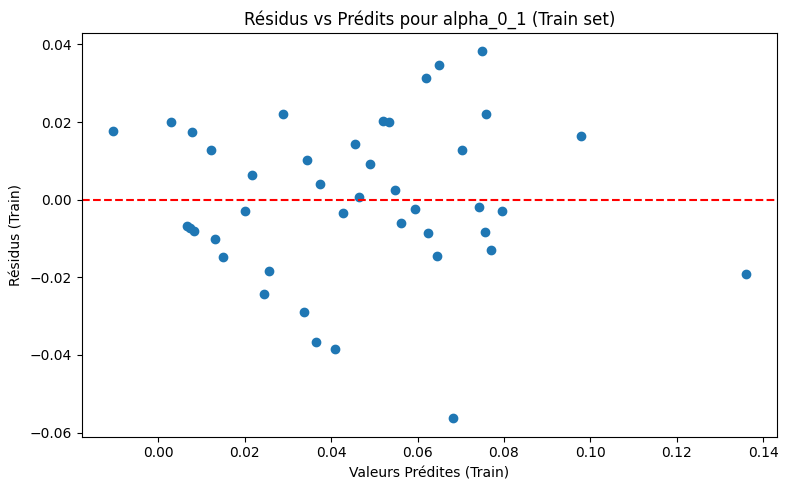

42   0.00370
43   0.00007
44   0.01134
45   0.00004
46   0.00329
47   0.00059
48   0.00014
49   0.00050
50   0.00197
51   0.00012
52   0.00012
dtype: float64
0    0.00032
1    0.00017
2    0.00010
3    0.00048
4    0.00049
5    0.00058
6    0.00004
7    0.00007
8    0.00149
9    0.00146
10   0.00317
11   0.00099
12   0.00034
13   0.00001
14   0.00134
15   0.00016
16   0.00001
17   0.00001
18   0.00008
19   0.00016
20   0.00000
21   0.00040
22   0.00007
23   0.00001
24   0.00000
25   0.00027
26   0.00040
27   0.00084
28   0.00022
29   0.00030
30   0.00004
31   0.00041
32   0.00121
33   0.00004
34   0.00001
35   0.00011
36   0.00021
37   0.00005
38   0.00002
39   0.00037
40   0.00007
41   0.00021
dtype: float64

--- Fin du script ---


In [ ]:
# --- Exécution Principale ---


# 7. Entraîner le modèle de régression et valider

# Standardiser les features X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_const = sm.add_constant(X_scaled, has_constant='add') # Ajoute une colonne de 1s

regression_results = {}

# Exemple : Prédire le premier terme d'interaction alpha_0_1
target_param = f'alpha_{0}_{1}' if N_STOCKS_ACTUAL > 1 else f'alpha_{0}_{0}' # Assurer que l'index existe

if target_param not in Y.columns:
    print(f"Erreur: Paramètre cible '{target_param}' introuvable dans Y.")
    print("Paramètres disponibles:", list(Y.columns))
    exit()

# Vérifier qu'il y a plus d'observations que de prédicteurs
if X_scaled_const.shape[0] <= X_scaled_const.shape[1]:
    print(f"Pas assez d'observations ({X_scaled_const.shape[0]}) pour le nombre de prédicteurs ({X_scaled_const.shape[1]}). Régression impossible.")
    exit()

y_target = Y[target_param]

# Séparer train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_const, y_target, test_size=0.2, random_state=42, shuffle=False) # Ne pas mélanger pour les séries temporelles

print(f"\nEntraînement du modèle de régression pour {target_param}...")

# Utilisation de statsmodels
try:
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    print(f"\n--- Résultats de la Régression OLS pour {target_param} ---")
    print(results.summary())
    y_train_pred = results.predict(X_train)
    train_rmse = np.sqrt(np.mean((y_train - y_train_pred)**2))

    # Évaluation sur le set de test
    # Assurer que X_test a les mêmes colonnes que X_train
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    y_pred = results.predict(X_test)
    test_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    print(f"\nRMSE sur l'ensemble d'entraînement pour {target_param}: {train_rmse:.4f}")
    print(f"\nRMSE sur l'ensemble de test pour {target_param}: {test_rmse:.4f}")
    print(f"Moyenne de {target_param} (test): {y_test.mean():.4f}")
    print(f"Écart-type de {target_param} (test): {y_test.std():.4f}")

    # Plot des résidus vs prédits (simple vérification)
    plt.figure(figsize=(8, 5))
    plt.scatter(results.predict(X_train), results.resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Valeurs Prédites (Train)")
    plt.ylabel("Résidus (Train)")
    plt.title(f"Résidus vs Prédits pour {target_param} (Train set)")
    plt.tight_layout()
    plt.show()

    print((y_test- y_pred)**2)
    print((y_train_pred - y_train)**2)

except Exception as e_reg:
     print(f"Erreur lors de l'entraînement/évaluation de la régression: {e_reg}")


print("\n--- Fin du script ---")